# Setup

The implementation is given by: https://keras.io/examples/vision/image_classification_with_vision_transformer/

In [2]:
!pip install tensorflow-addons
!pip install tensorflow==2.8.3 # Due a bug in DataAugmentation in newer versions 
# of tensorflow
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 53.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.4/498.4 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.3/462.3 KB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 75.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 3.5 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.11.0
    Uninstalling tensorflow-estimator-2.11.0:
      Successfully uninstalled tensorflow-estimator-2.11.0
  Attempting uninstall: keras
    Found existing installation: keras 2.11.0
    Uninstalling keras-2.11.0:
      

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow_addons.optimizers import AdamW
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import pickle
import keras_tuner

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.3 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [4]:
!nvidia-smi

Tue Feb 14 11:02:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    55W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Feb 14 11:02:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    55W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


# Prepare the data

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
dataset_dir = "gdrive/MyDrive/hyper-kvasir-dataset-final"

In [9]:
def get_dataCategories(dataset_dir):
    import glob

    categories = []
    for folder_name in os.listdir(dataset_dir):
        if os.path.isdir(os.path.join(dataset_dir, folder_name)):
            nbr_files = len(
                glob.glob(os.path.join(dataset_dir, folder_name) + "/*.jpg")
            )
            categories.append(np.array([folder_name, nbr_files]))

    categories.sort(key=lambda a: a[0])
    cat = np.array(categories)

    return list(cat[:, 0]), list(cat[:, 1])

categories, nbr_files = get_dataCategories(dataset_dir)

# Create DataFrame
df = pd.DataFrame({"categorie": categories, "numbre of files": nbr_files})
print("number of categories: ", len(categories))
df

number of categories:  23


,categorie,numbre of files
0,barretts,41
1,barretts-short-segment,53
2,bbps-0-1,646
3,bbps-2-3,1158
4,cecum,1027
5,dyed-lifted-polyps,1002
6,dyed-resection-margins,989
7,esophagitis-a,413
8,esophagitis-b-d,260
9,hemorrhoids,6


## Obtaining the entire data and labels

In [10]:
def get_x_y(datadir, categories, img_wid, img_high):
    X, y = [], []
    for category in categories:
        path = os.path.join(datadir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                ima_resize_rgb = cv2.resize(img_array, (img_wid, img_high))

                X.append(ima_resize_rgb)
                y.append(class_num)

            except Exception as e:
                print(e)

    y = np.array(y)
    X = np.array(X)

    # reshape X into img_wid x img_high x 3
    X = X.reshape(X.shape[0], img_wid, img_high, 3)

    return X, y


img_wid, img_high = 224, 224
X, y = get_x_y(dataset_dir, categories, img_wid, img_high)

print(f"X: {X.shape}")
print(f"y: {y.shape}")

X: (10740, 224, 224, 3)
y: (10740,)


## Visualize the data

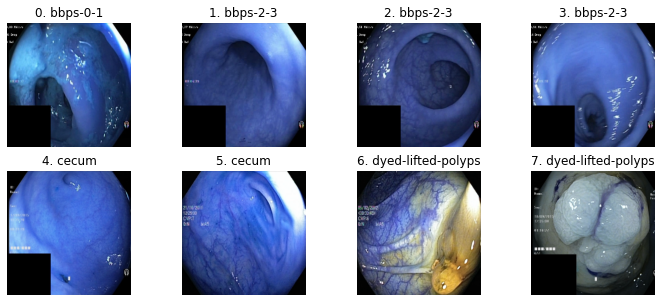

In [ ]:
plt.figure(figsize=(12, 5))
st, end = 0, 500
for i in range(8):
    plt.subplot(2, 4, i + 1)
    idx = np.random.randint(st, end)
    st = end + 1
    end = (i + 2) * 500
    plt.imshow(X[idx][:, :, ::-1])
    plt.title(f"{i}. {categories[y[idx]]}")
    plt.axis("off")
plt.show()

## Split the data into train and test

In [11]:
Y = np.reshape(y, (len(y), 1))


X_train, X_test, y_train, y_test = train_test_split(
    X, Y, train_size=0.8, random_state=42
)

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (8592, 224, 224, 3)
y_train: (8592, 1)
X_test: (2148, 224, 224, 3)
y_test: (2148, 1)


# Data augmentation

In [12]:
# Data augmentation

image_size = 224

data_augmentation = keras.Sequential(
    [
        keras.layers.Normalization(),
        keras.layers.Resizing(image_size, image_size),
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(factor=0.02),
        keras.layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

# Building the ViT model

[Model diagram](https://viso.ai/wp-content/uploads/2021/09/vision-transformer-vit.png)

## Multi-Layer-Perceptron (MLP)

In [13]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Patch creation layer

In [14]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


## Hyper-parameters

In [15]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 250
image_size = 224  # We'll resize input images to this size
patch_size = 24  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier
seed = 1

(-0.5, 223.5, 223.5, -0.5)

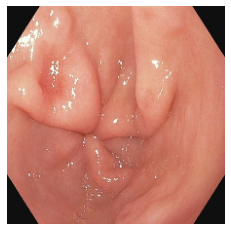

In [ ]:
plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

Image size: 224 X 224
Patch size: 24 X 24
Patches per image: 81
Elements per patch: 1728


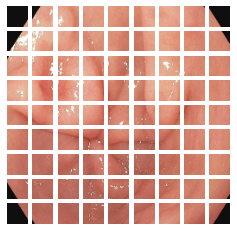

In [ ]:
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

## Patch encoding layer

In [16]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


# Final ViT model

In [15]:
num_classes = 23
input_shape = (224, 224, 3)

def optimize_vit_classifier(hp):

    # Five steps approach to select a initial seed
    tf.random.set_seed(hp.Choice('seed', [1, 2]))

    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patch_size = hp.Choice('patch_size', [12, 18, 24])
    num_patches = (image_size // patch_size) ** 2
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    projection_dim = hp.Choice('projection_dim', [16, 32, 64, 128])
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    transformer_units = [
      projection_dim * 2,
      projection_dim,
    ]

    # Create multiple layers of the Transformer block.
    for _ in range(hp.Choice('transformer_layers', [4, 8, 12, 16])):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)

    # Compiling the final  model 
    optimizer = AdamW(
        learning_rate=hp.Choice('learning_rate', [0.00001, 0.0001, 0.001, 0.01]), weight_decay=hp.Choice('weight_decay', [0.00001, 0.0001, 0.001, 0.01])
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")
        ],
    )

    return model


# Pre-tunning

In [ ]:
from keras_tuner import RandomSearch

# tuner for function
tuner = RandomSearch(
    optimize_vit_classifier,
    objective='val_accuracy',
    max_trials=10000,
    overwrite=True,
    executions_per_trial=1)

In [ ]:
tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best learning rate: {best_hps.get('learning_rate')}")
print(f"Best weight_decay: {best_hps.get('weight_decay')}")
print(f"Best projection_dim: {best_hps.get('projection_dim')}")
print(f"Best transfomers units: [{int(best_hps.get('projection_dim')) * 2}, {best_hps.get('projection_dim')}]")
print(f"transformer_layers: {best_hps.get('transformer_layers')}")
print(f"Best patch_size: {best_hps.get('patch_size')}")
print(f"Best number of patches: {(image_size // int(best_hps.get('patch_size'))) ** 2}")
print(f"Best seed: {best_hps.get('seed')}")

# Using W&D Tunning

In [17]:
!pip install wandb
!wandb login

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 70.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 KB 23.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 18.5 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=70e78e7bbf900ba2bc00dc211b6b71961595d4d1522e762e58d469765e9cdc36
  Stored in directory: /root/.cache/pip/wheels/4c/8e/7e/72fbc243e1aeecae64a96875432e70d4e92f3d2d18123be004
Successfully built pathtools
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [18]:
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
import os

os.environ['WANDB_NOTEBOOK_NAME'] = 'gdrive/MyDrive/Universidad/TFG/notebooks/2.2-rep-first-vit-tf-from-scratch-tunner-f1.ipynb'

wandb.login()

wandb: Currently logged in as: richardesp (ava-research-hyper-kvasir). Use `wandb login --relogin` to force relogin


True

In [58]:
num_classes = 23
input_shape = (224, 224, 3)

def get_vit_classifier(seed: float, patch_size: int, projection_dim: int, transformers_layer: int,
                            learning_rate: float, weight_decay: float):

    # Five steps approach to select a initial seed
    import numpy.random
    np.random.seed(seed)

    import tensorflow as tf
    tf.random.set_seed(seed)

    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    num_patches = (image_size // patch_size) ** 2
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    transformer_units = [
      projection_dim * 2,
      projection_dim,
    ]

    # Create multiple layers of the Transformer block.
    for _ in range(transformers_layer):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)

    # Compiling the final  model 
    optimizer = AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy")
        ],
    )

    return model


In [24]:
sweep_config = {
    'method': 'bayes'
}


metric = {
    'name': 'val_accuracy',
    'goal': 'maximize'   
}

sweep_config['metric'] = metric

parameters_dict = {
    'seed': {
        'values': [1, 2, 3, 4, 5]
        },
    'patch_size': {
          'values': [12, 16, 20, 24]
        },
    'projection_dim': {
          'values': [16, 32, 64, 128]
        },
    'transfomers_layers': {
          'values': [4, 8, 12, 16]
        },
    'learning_rate': {
        'values': [0.00001, 0.0001, 0.001, 0.01]
    },
    'weight_decay': {
        'values': [0.00001, 0.0001, 0.001, 0.01]
    },
    'batch_size': {
        'values': [32, 64, 128, 256]
    }
}

sweep_config['parameters'] = parameters_dict


parameters_dict.update({
    'epochs': {
        'value': 30
    }
})

In [25]:
import pprint

pprint.pprint(sweep_config)

{'method': 'bayes',
 'metric': {'goal': 'maximize', 'name': 'val_accuracy'},
 'parameters': {'batch_size': {'values': [32, 64, 128, 256]},
                'epochs': {'value': 30},
                'learning_rate': {'values': [1e-05, 0.0001, 0.001, 0.01]},
                'patch_size': {'values': [12, 16, 20, 24]},
                'projection_dim': {'values': [16, 32, 64, 128]},
                'seed': {'values': [1, 2, 3, 4, 5]},
                'transfomers_layers': {'values': [4, 8, 12, 16]},
                'weight_decay': {'values': [1e-05, 0.0001, 0.001, 0.01]}}}


In [68]:
from sklearn.metrics import f1_score, precision_score, recall_score

class MetricsCallback(keras.callbacks.Callback):
    def __init__(self):
        super(MetricsCallback, self).__init__()

    def  on_train_begin(self,logs={}):
      self.f1_macro = []
      self.f1_micro = []
      self.precision_macro = []
      self.precision_micro = []
      self.recall_macro = []
      self.recall_micro = []

    def on_epoch_end(self, epoch, logs=None):
      y_pred = self.model.predict(X_test).round().argmax(axis=1)
      y_true = y_test

      score_f1_macro = f1_score(y_true, y_pred, average='macro')
      score_f1_micro = f1_score(y_true, y_pred, average='micro')
      score_precision_macro = precision_score(y_true, y_pred, average='macro', zero_division=0)
      score_precision_micro = precision_score(y_true, y_pred, average='micro', zero_division=0)
      score_recall_macro = recall_score(y_true, y_pred, average='macro')
      score_recall_micro = recall_score(y_true, y_pred, average='micro')

      self.f1_macro.append(score_f1_macro)
      self.f1_micro.append(score_f1_micro)
      self.precision_macro.append(score_precision_macro)
      self.precision_micro.append(score_precision_micro)
      self.recall_macro.append(score_recall_macro)
      self.recall_micro.append(score_recall_micro)

      best_f1_score_macro = max(self.f1_macro)
      best_f1_score_macro_epoch = self.f1_macro.index(best_f1_score_macro)

      best_f1_score_micro = max(self.f1_micro)
      best_f1_score_micro_epoch = self.f1_micro.index(best_f1_score_micro)

      # We have to calculate the F1 score at the end of every epoch, because
      # tensorflow works by batches for another metrics computing, so it's
      # required to create a custom callback to perform F1 score

      print(f""" - val_f1_macro: {score_f1_macro} - val_f1_micro: {score_f1_micro}
       - val_precision_macro: {score_precision_macro} - val_precision_micro: {score_precision_micro} - val_recall_macro: {score_recall_macro} - val_recall_micro: {score_recall_micro}
       - val_best_f1_score_macro: {best_f1_score_macro} (epoch: {best_f1_score_macro_epoch}) - val_best_f1_score_micro: {best_f1_score_micro} (epoch: {best_f1_score_micro})""")

      wandb.log({'epoch/val_f1_macro': score_f1_macro}, commit=True)
      wandb.log({'epoch/val_f1_micro': score_f1_micro}, commit=True)
      wandb.log({'epoch/val_precision_macro': score_precision_macro}, commit=True)
      wandb.log({'epoch/val_precision_micro': score_precision_micro}, commit=True)
      wandb.log({'epoch/val_recall_macro': score_recall_macro}, commit=True)
      wandb.log({'epoch/val_recall_micro': score_recall_micro}, commit=True)
      wandb.log({'best_f1_score_macro': best_f1_score_macro}, commit=True)
      wandb.log({'best_f1_score_micro': best_f1_score_micro}, commit=True)

metrics = MetricsCallback()

In [28]:
from tensorflow.keras.callbacks import EarlyStopping

def sweep_train(config_defaults=None):
    # Initialize wandb with a sample project name
    with wandb.init(config=config_defaults):  # this gets over-written in the Sweep

        # Specify the other hyperparameters to the configuration, if any
        wandb.config.architecture_name = "vit-scratch"
        wandb.config.dataset_name = "Hyper-Kvasir"

        # initialize model
        model = get_vit_classifier(wandb.config.seed, wandb.config.patch_size, wandb.config.projection_dim,
                                   wandb.config.transfomers_layers, wandb.config.learning_rate, wandb.config.weight_decay)

        # callback setup
        wandb_callbacks = [
            WandbMetricsLogger(), # We can add a checkpoint
            metrics,
            EarlyStopping(monitor='val_accuracy', patience=3)
        ]

        model.fit(X_train, 
                  y_train, 
                  batch_size=wandb.config.batch_size, 
                  epochs=wandb.config.epochs, 
                  validation_data=(X_test, y_test), 
                  callbacks=wandb_callbacks)

In [29]:
sweep_id = wandb.sweep(sweep_config, project="hyper-kvasir-optimization-models-f1", entity="ava-research-hyper-kvasir")

Create sweep with ID: yq5f6lll
Sweep URL: https://wandb.ai/ava-research-hyper-kvasir/hyper-kvasir-optimization-models-f1/sweeps/yq5f6lll


In [ ]:
wandb.agent(sweep_id, function=sweep_train, count=10000)

wandb: Agent Starting Run: bw4gfr3x with config:
wandb: 	batch_size: 256
wandb: 	epochs: 30
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 24
wandb: 	projection_dim: 16
wandb: 	seed: 3
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.001


Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 5.3752 - accuracy: 0.2379 - top-5-accuracy: 0.6327 - val_f1_macro: 0.19904698648279331 - val_f1_micro: 0.3957169459962756
       - val_precision_macro: 0.25090336715047673 - val_precision_micro: 0.3957169459962756 - val_recall_macro: 0.21661249376445554 - val_recall_micro: 0.3957169459962756
34/34 [==============================] - 27s 255ms/step - loss: 5.3752 - accuracy: 0.2379 - top-5-accuracy: 0.6327 - val_loss: 1.7567 - val_accuracy: 0.4125 - val_top-5-accuracy: 0.8585
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 2.0616 - accuracy: 0.3518 - top-5-accuracy: 0.8219 - val_f1_macro: 0.16978766125868894 - val_f1_micro: 0.4003724394785847
       - val_precision_macro: 0.18306553158422179 - val_precision_micro: 0.40037243947858475 - val_recall_macro: 0.2128104872988696 - val_recall_micro: 0.40037243947858475
34/34 [==============================] - 5s 138ms/step - loss: 2.0616 - accuracy: 0.3518 - 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


34/34 [==============================] - ETA: 0s - loss: 1.8808 - accuracy: 0.3869 - top-5-accuracy: 0.8546 - val_f1_macro: 0.21950349034151673 - val_f1_micro: 0.43435754189944137
       - val_precision_macro: 0.259181645226998 - val_precision_micro: 0.43435754189944137 - val_recall_macro: 0.23103811559807894 - val_recall_micro: 0.43435754189944137
34/34 [==============================] - 5s 138ms/step - loss: 1.8808 - accuracy: 0.3869 - top-5-accuracy: 0.8546 - val_loss: 1.5315 - val_accuracy: 0.4669 - val_top-5-accuracy: 0.9171
Epoch 4/30
34/34 [==============================] - ETA: 0s - loss: 1.7494 - accuracy: 0.4263 - top-5-accuracy: 0.8792 - val_f1_macro: 0.26620627997208446 - val_f1_micro: 0.5023277467411545
       - val_precision_macro: 0.26821349751619467 - val_precision_micro: 0.5023277467411545 - val_recall_macro: 0.28613036194348757 - val_recall_micro: 0.5023277467411545
34/34 [==============================] - 5s 136ms/step - loss: 1.7494 - accuracy: 0.4263 - top-5-accura

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


34/34 [==============================] - ETA: 0s - loss: 1.0809 - accuracy: 0.6214 - top-5-accuracy: 0.9624 - val_f1_macro: 0.38788588951866276 - val_f1_micro: 0.6769087523277467
       - val_precision_macro: 0.44312195984950387 - val_precision_micro: 0.6769087523277467 - val_recall_macro: 0.39813737864489573 - val_recall_micro: 0.6769087523277467
34/34 [==============================] - 5s 138ms/step - loss: 1.0809 - accuracy: 0.6214 - top-5-accuracy: 0.9624 - val_loss: 0.7894 - val_accuracy: 0.6890 - val_top-5-accuracy: 0.9804
Epoch 16/30
34/34 [==============================] - ETA: 0s - loss: 1.0417 - accuracy: 0.6280 - top-5-accuracy: 0.9654 - val_f1_macro: 0.3547607868788813 - val_f1_micro: 0.648975791433892
       - val_precision_macro: 0.4029567048409495 - val_precision_micro: 0.648975791433892 - val_recall_macro: 0.3792328422671741 - val_recall_micro: 0.648975791433892
34/34 [==============================] - 5s 137ms/step - loss: 1.0417 - accuracy: 0.6280 - top-5-accuracy: 0.

epoch/accuracy,▁▃▄▄▅▅▆▇▇▇▇█████
epoch/epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch/top-5-accuracy,▁▅▆▆▆▇▇▇████████
epoch/val_accuracy,▁▁▂▄▅▆▆▆▇▇▇█████
epoch/val_f1_macro,▂▁▃▄▅▅▆▆▆▆▆▇█▇█▇
epoch/val_f1_micro,▁▁▂▄▄▅▆▆▆▇▇▇▇▇█▇
epoch/val_loss,█▇▆▅▅▄▃▃▂▂▂▁▁▂▁▁
epoch/val_precision_macro,▃▁▃▃▅▅▆▆▆▆▅▇█▆▇▆
epoch/val_precision_micro,▁▁▂▄▄▅▆▆▆▇▇▇▇▇█▇


wandb: Agent Starting Run: m3aah2ph with config:
wandb: 	batch_size: 256
wandb: 	epochs: 30
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 12
wandb: 	projection_dim: 128
wandb: 	seed: 5
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.01


Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 132.2034 - accuracy: 0.1176 - top-5-accuracy: 0.4238 - val_f1_macro: 0.023364899758748395 - val_f1_micro: 0.11824953445065177
       - val_precision_macro: 0.0480018927821676 - val_precision_micro: 0.11824953445065177 - val_recall_macro: 0.05318053241391845 - val_recall_micro: 0.11824953445065177
34/34 [==============================] - 39s 697ms/step - loss: 132.2034 - accuracy: 0.1176 - top-5-accuracy: 0.4238 - val_loss: 2.7333 - val_accuracy: 0.1280 - val_top-5-accuracy: 0.4777
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 2.6903 - accuracy: 0.1151 - top-5-accuracy: 0.4943 - val_f1_macro: 0.03152314727049736 - val_f1_micro: 0.11778398510242086
       - val_precision_macro: 0.14868976405439283 - val_precision_micro: 0.11778398510242086 - val_recall_macro: 0.06268610661241826 - val_recall_micro: 0.11778398510242086
34/34 [==============================] - 20s 586ms/step - loss: 2.6903 - accuracy:

epoch/accuracy,▁▁▂▅▇█
epoch/epoch,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇██████
epoch/learning_rate,▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁
epoch/top-5-accuracy,▁▂▄▆▇█
epoch/val_accuracy,▁▁▃▆▇█
epoch/val_f1_macro,▁▁▂▅▇█
epoch/val_f1_micro,▁▁▂▅▇█
epoch/val_loss,█▇▆▃▂▁
epoch/val_precision_macro,▁▅▃▅▇█
epoch/val_precision_micro,▁▁▂▅▇█


Run m3aah2ph errored: ResourceExhaustedError()
wandb: ERROR Run m3aah2ph errored: ResourceExhaustedError()
wandb: Agent Starting Run: ufe5j6l4 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 30
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 24
wandb: 	projection_dim: 32
wandb: 	seed: 1
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.001


Epoch 1/30
67/68 [============================>.] - ETA: 0s - loss: 3.7979 - accuracy: 0.1191 - top-5-accuracy: 0.4011 - val_f1_macro: 0.14465440186055362 - val_f1_micro: 0.3542830540037244
       - val_precision_macro: 0.1637520750380554 - val_precision_micro: 0.3542830540037244 - val_recall_macro: 0.17539319666198722 - val_recall_micro: 0.3542830540037244
68/68 [==============================] - 11s 77ms/step - loss: 3.7954 - accuracy: 0.1194 - top-5-accuracy: 0.4018 - val_loss: 2.0823 - val_accuracy: 0.4134 - val_top-5-accuracy: 0.8338
Epoch 2/30
67/68 [============================>.] - ETA: 0s - loss: 2.6254 - accuracy: 0.2409 - top-5-accuracy: 0.6414 - val_f1_macro: 0.1604227660712224 - val_f1_micro: 0.3873370577281191
       - val_precision_macro: 0.18786265161965723 - val_precision_micro: 0.38733705772811916 - val_recall_macro: 0.19314066118363274 - val_recall_micro: 0.38733705772811916
68/68 [==============================] - 3s 51ms/step - loss: 2.6247 - accuracy: 0.2408 - top

epoch/accuracy,▁▄▅▇▇██
epoch/epoch,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█████
epoch/learning_rate,▁▁▁▁▁▁▁
epoch/loss,█▄▂▁▁▁▁
epoch/top-5-accuracy,▁▅▆▇███
epoch/val_accuracy,▁▆██▇▆▅
epoch/val_f1_macro,▁▅█████
epoch/val_f1_micro,▁▅▇████
epoch/val_loss,█▃▁▁▁▂▃
epoch/val_precision_macro,▁▃▄▄▄█▇
epoch/val_precision_micro,▁▅▇████


wandb: Agent Starting Run: 3olxp1xy with config:
wandb: 	batch_size: 256
wandb: 	epochs: 30
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 12
wandb: 	projection_dim: 16
wandb: 	seed: 2
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 1e-05


Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 13.0911 - accuracy: 0.1920 - top-5-accuracy: 0.5560 - val_f1_macro: 0.12737791924679123 - val_f1_micro: 0.30121042830540035
       - val_precision_macro: 0.18248290421586477 - val_precision_micro: 0.30121042830540035 - val_recall_macro: 0.15433684367577225 - val_recall_micro: 0.30121042830540035
34/34 [==============================] - 37s 524ms/step - loss: 13.0911 - accuracy: 0.1920 - top-5-accuracy: 0.5560 - val_loss: 2.0511 - val_accuracy: 0.3440 - val_top-5-accuracy: 0.7277
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 2.5287 - accuracy: 0.1941 - top-5-accuracy: 0.6164 - val_f1_macro: 0.10386720066663578 - val_f1_micro: 0.2574487895716946
       - val_precision_macro: 0.1314530000588976 - val_precision_micro: 0.2574487895716946 - val_recall_macro: 0.1325005187192745 - val_recall_micro: 0.2574487895716946
34/34 [==============================] - 13s 377ms/step - loss: 2.5287 - accuracy: 0.1941

epoch/accuracy,▁▂▅█
epoch/epoch,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▆▆▆▆▆▆▆███████
epoch/learning_rate,▁▁▁▁
epoch/loss,█▁▁▁
epoch/top-5-accuracy,▁▅▅█
epoch/val_accuracy,█▄▁█
epoch/val_f1_macro,█▅▁▆
epoch/val_f1_micro,█▄▁▇
epoch/val_loss,▁▄█▁
epoch/val_precision_macro,█▃▁█
epoch/val_precision_micro,█▄▁▇


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vmsbu1d9 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 24
wandb: 	projection_dim: 32
wandb: 	seed: 4
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.0001


Epoch 1/30
134/135 [============================>.] - ETA: 0s - loss: 3.7668 - accuracy: 0.1328 - top-5-accuracy: 0.4443 - val_f1_macro: 0.13920263459184223 - val_f1_micro: 0.35986964618249534
       - val_precision_macro: 0.16535380715825204 - val_precision_micro: 0.35986964618249534 - val_recall_macro: 0.17906250645402486 - val_recall_micro: 0.35986964618249534
135/135 [==============================] - 22s 80ms/step - loss: 3.7666 - accuracy: 0.1328 - top-5-accuracy: 0.4441 - val_loss: 1.9655 - val_accuracy: 0.3841 - val_top-5-accuracy: 0.8333
Epoch 2/30
135/135 [==============================] - ETA: 0s - loss: 2.8090 - accuracy: 0.2486 - top-5-accuracy: 0.6562 - val_f1_macro: 0.16452757077421537 - val_f1_micro: 0.3952513966480447
       - val_precision_macro: 0.19744184147235788 - val_precision_micro: 0.3952513966480447 - val_recall_macro: 0.2004588146337735 - val_recall_micro: 0.3952513966480447
135/135 [==============================] - 8s 58ms/step - loss: 2.8090 - accuracy: 0.

epoch/accuracy,▁▃▃▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇███████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/top-5-accuracy,▁▄▅▆▆▇▇▇▇▇▇▇██████████████████
epoch/val_accuracy,▁▃▃▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇████████
epoch/val_f1_macro,▁▂▃▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████
epoch/val_f1_micro,▁▂▃▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████
epoch/val_loss,█▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch/val_precision_macro,▁▂▅▅▇▆▆▆▆▆▆▇▆▇▆▆▇▆▇▇▇▇▇███████
epoch/val_precision_micro,▁▂▃▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████


wandb: Agent Starting Run: prll9oih with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 20
wandb: 	projection_dim: 32
wandb: 	seed: 5
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 1e-05


Epoch 1/30
269/269 [==============================] - ETA: 0s - loss: 2.3500 - accuracy: 0.3700 - top-5-accuracy: 0.7945 - val_f1_macro: 0.27596567844276676 - val_f1_micro: 0.5633147113594041
       - val_precision_macro: 0.32833059645994694 - val_precision_micro: 0.5633147113594041 - val_recall_macro: 0.2986891990205347 - val_recall_micro: 0.5633147113594041
269/269 [==============================] - 17s 40ms/step - loss: 2.3500 - accuracy: 0.3700 - top-5-accuracy: 0.7945 - val_loss: 1.2315 - val_accuracy: 0.5610 - val_top-5-accuracy: 0.9548
Epoch 2/30
269/269 [==============================] - ETA: 0s - loss: 1.5789 - accuracy: 0.5120 - top-5-accuracy: 0.9053 - val_f1_macro: 0.326207905486025 - val_f1_micro: 0.6061452513966481
       - val_precision_macro: 0.41107313459777833 - val_precision_micro: 0.6061452513966481 - val_recall_macro: 0.33574837182362893 - val_recall_micro: 0.6061452513966481
269/269 [==============================] - 9s 34ms/step - loss: 1.5789 - accuracy: 0.5120 

epoch/accuracy,▁▄▅▅▅▆▆▆▇▇▇▇▇▇██████
epoch/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch/top-5-accuracy,▁▅▆▇▇▇▇▇████████████
epoch/val_accuracy,▁▃▃▄▅▅▅▅▇▆▇▇▇▇█▇█▇██
epoch/val_f1_macro,▁▃▃▄▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇█
epoch/val_f1_micro,▁▃▃▄▄▅▅▄▆▆▇▆▇▇▇▇██▇█
epoch/val_loss,█▆▆▅▄▄▃▄▃▂▂▂▂▂▁▂▁▁▁▁
epoch/val_precision_macro,▁▄▃▅▃▃▆▅▆▇▆▇▆▇▇▇█▇██
epoch/val_precision_micro,▁▃▃▄▄▅▅▄▆▆▇▆▇▇▇▇██▇█


wandb: Agent Starting Run: kw42x3f9 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 12
wandb: 	projection_dim: 64
wandb: 	seed: 2
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.01


Epoch 1/30
134/135 [============================>.] - ETA: 0s - loss: 2.2134 - accuracy: 0.4548 - top-5-accuracy: 0.8604 - val_f1_macro: 0.2853184086499214 - val_f1_micro: 0.5507448789571695
       - val_precision_macro: 0.31199662799425426 - val_precision_micro: 0.5507448789571695 - val_recall_macro: 0.30456162836556727 - val_recall_micro: 0.5507448789571695
135/135 [==============================] - 26s 118ms/step - loss: 2.2112 - accuracy: 0.4550 - top-5-accuracy: 0.8607 - val_loss: 1.2050 - val_accuracy: 0.5745 - val_top-5-accuracy: 0.9502
Epoch 2/30
134/135 [============================>.] - ETA: 0s - loss: 1.3125 - accuracy: 0.5517 - top-5-accuracy: 0.9420 - val_f1_macro: 0.24352489746221265 - val_f1_micro: 0.49860335195530725
       - val_precision_macro: 0.31508538394873564 - val_precision_micro: 0.49860335195530725 - val_recall_macro: 0.2811958947440116 - val_recall_micro: 0.49860335195530725
135/135 [==============================] - 12s 91ms/step - loss: 1.3117 - accuracy: 0

epoch/accuracy,▁█▇▇
epoch/epoch,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▆▆▆▆▆▆▆███████
epoch/learning_rate,▁▁▁▁
epoch/loss,█▁▁▁
epoch/top-5-accuracy,▁███
epoch/val_accuracy,█▅▁▆
epoch/val_f1_macro,█▃▁▅
epoch/val_f1_micro,█▃▁█
epoch/val_loss,▁█▆▃
epoch/val_precision_macro,██▁▂
epoch/val_precision_micro,█▃▁█


wandb: Agent Starting Run: t7i1oywd with config:
wandb: 	batch_size: 256
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 12
wandb: 	projection_dim: 32
wandb: 	seed: 3
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.01


Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 2.4290 - accuracy: 0.4225 - top-5-accuracy: 0.8245 - val_f1_macro: 0.312153902982423 - val_f1_micro: 0.5819366852886406
       - val_precision_macro: 0.3378414705860837 - val_precision_micro: 0.5819366852886406 - val_recall_macro: 0.32964487171740736 - val_recall_micro: 0.5819366852886406
34/34 [==============================] - 12s 197ms/step - loss: 2.4290 - accuracy: 0.4225 - top-5-accuracy: 0.8245 - val_loss: 1.1505 - val_accuracy: 0.5968 - val_top-5-accuracy: 0.9530
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.2248 - accuracy: 0.5743 - top-5-accuracy: 0.9475 - val_f1_macro: 0.31232977422483027 - val_f1_micro: 0.5721601489757915
       - val_precision_macro: 0.36880798334046766 - val_precision_micro: 0.5721601489757915 - val_recall_macro: 0.33235351798773266 - val_recall_micro: 0.5721601489757915
34/34 [==============================] - 5s 143ms/step - loss: 1.2248 - accuracy: 0.5743 - top-

epoch/accuracy,▁▆████
epoch/epoch,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇██████
epoch/learning_rate,▁▁▁▁▁▁
epoch/loss,█▂▁▁▁▁
epoch/top-5-accuracy,▁▇████
epoch/val_accuracy,▂▁█▇▆▅
epoch/val_f1_macro,▁▁▇▂█▅
epoch/val_f1_micro,▃▁█▆█▂
epoch/val_loss,█▄▁▃▁▂
epoch/val_precision_macro,▁▆▅▃▃█
epoch/val_precision_micro,▃▁█▆█▂


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: s3wgfs1b with config:
wandb: 	batch_size: 256
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 20
wandb: 	projection_dim: 16
wandb: 	seed: 1
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 1e-05


Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 2.1653 - accuracy: 0.3897 - top-5-accuracy: 0.8193 - val_f1_macro: 0.29948300205799766 - val_f1_micro: 0.5521415270018621
       - val_precision_macro: 0.36343270295392704 - val_precision_micro: 0.5521415270018621 - val_recall_macro: 0.31237805606457586 - val_recall_micro: 0.5521415270018621
34/34 [==============================] - 25s 261ms/step - loss: 2.1653 - accuracy: 0.3897 - top-5-accuracy: 0.8193 - val_loss: 1.2247 - val_accuracy: 0.5750 - val_top-5-accuracy: 0.9446
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.3547 - accuracy: 0.5525 - top-5-accuracy: 0.9370 - val_f1_macro: 0.33727090880899685 - val_f1_micro: 0.5847299813780261
       - val_precision_macro: 0.37614710486257047 - val_precision_micro: 0.5847299813780261 - val_recall_macro: 0.35108686437752046 - val_recall_micro: 0.5847299813780261
34/34 [==============================] - 5s 149ms/step - loss: 1.3547 - accuracy: 0.5525 - t

epoch/accuracy,▁▄▅▅▆▆▆▆▇▇▇▇▇▇████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch/top-5-accuracy,▁▆▇▇▇▇▇███████████████
epoch/val_accuracy,▁▂▃▅▅▆▆▆▇▇▇▇█▇████████
epoch/val_f1_macro,▁▂▃▅▅▅▆▇▆▇▇▇█▇█▇▇▇████
epoch/val_f1_micro,▁▂▃▅▅▆▆▆▅▇▆▇█▇▇▇▇▇████
epoch/val_loss,█▆▅▄▄▃▃▃▂▂▂▂▂▁▁▁▂▁▁▁▁▁
epoch/val_precision_macro,▁▂▂▄▄▆▅▆▆▇▇▇▇▆█▇▇▇█▇▇▇
epoch/val_precision_micro,▁▂▃▅▅▆▆▆▅▇▆▇█▇▇▇▇▇████


wandb: Agent Starting Run: hik8het9 with config:
wandb: 	batch_size: 256
wandb: 	epochs: 30
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 20
wandb: 	projection_dim: 128
wandb: 	seed: 3
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 1e-05


Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 4.2227 - accuracy: 0.1761 - top-5-accuracy: 0.5077 - val_f1_macro: 0.1227850884901363 - val_f1_micro: 0.35381750465549344
       - val_precision_macro: 0.20714572756274496 - val_precision_micro: 0.3538175046554935 - val_recall_macro: 0.17458950207181664 - val_recall_micro: 0.3538175046554935
34/34 [==============================] - 12s 209ms/step - loss: 4.2227 - accuracy: 0.1761 - top-5-accuracy: 0.5077 - val_loss: 2.1525 - val_accuracy: 0.3575 - val_top-5-accuracy: 0.8338
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 3.1267 - accuracy: 0.2782 - top-5-accuracy: 0.7005 - val_f1_macro: 0.18045438612971867 - val_f1_micro: 0.43202979515828677
       - val_precision_macro: 0.24432895225881127 - val_precision_micro: 0.43202979515828677 - val_recall_macro: 0.2184754420121742 - val_recall_micro: 0.43202979515828677
34/34 [==============================] - 4s 120ms/step - loss: 3.1267 - accuracy: 0.2782 -

epoch/accuracy,▁▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/top-5-accuracy,▁▄▅▆▆▆▆▇▇▇▇▇▇▇▇███████████████
epoch/val_accuracy,▁▃▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█▇████████
epoch/val_f1_macro,▁▃▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇████
epoch/val_f1_micro,▁▃▄▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████
epoch/val_loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch/val_precision_macro,▁▂▂▃▄▅▅▅▅▆▆▆▅▆▆▆▆▅▆▆▆▆▆▆▇▆▆▆█▇
epoch/val_precision_micro,▁▃▄▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████


wandb: Agent Starting Run: rxbzuj76 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 16
wandb: 	projection_dim: 16
wandb: 	seed: 4
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.001


Epoch 1/30
135/135 [==============================] - ETA: 0s - loss: 3.4081 - accuracy: 0.1546 - top-5-accuracy: 0.4742 - val_f1_macro: 0.1321366396943355 - val_f1_micro: 0.3431098696461825
       - val_precision_macro: 0.14733085305836402 - val_precision_micro: 0.3431098696461825 - val_recall_macro: 0.16844999789214185 - val_recall_micro: 0.3431098696461825
135/135 [==============================] - 39s 144ms/step - loss: 3.4081 - accuracy: 0.1546 - top-5-accuracy: 0.4742 - val_loss: 2.0549 - val_accuracy: 0.3901 - val_top-5-accuracy: 0.8385
Epoch 2/30
135/135 [==============================] - ETA: 0s - loss: 2.3045 - accuracy: 0.2978 - top-5-accuracy: 0.7299 - val_f1_macro: 0.14010247067825268 - val_f1_micro: 0.35893854748603354
       - val_precision_macro: 0.13311725558277174 - val_precision_micro: 0.35893854748603354 - val_recall_macro: 0.1781837607527022 - val_recall_micro: 0.35893854748603354
135/135 [==============================] - 15s 109ms/step - loss: 2.3045 - accuracy: 

epoch/accuracy,▁▅▇██
epoch/epoch,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆███████
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▂▁▁▁
epoch/top-5-accuracy,▁▆▇██
epoch/val_accuracy,▂█▇▆▁
epoch/val_f1_macro,▇█▇▅▁
epoch/val_f1_micro,▆█▇▅▁
epoch/val_loss,▇▁▃▆█
epoch/val_precision_macro,█▆▇█▁
epoch/val_precision_micro,▆█▇▅▁


wandb: Agent Starting Run: z4knf044 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 12
wandb: 	projection_dim: 32
wandb: 	seed: 4
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 1e-05


Epoch 1/30
269/269 [==============================] - ETA: 0s - loss: 2.3339 - accuracy: 0.3934 - top-5-accuracy: 0.8135 - val_f1_macro: 0.3157325181163675 - val_f1_micro: 0.590782122905028
       - val_precision_macro: 0.3533881365556165 - val_precision_micro: 0.590782122905028 - val_recall_macro: 0.33131860491501114 - val_recall_micro: 0.590782122905028
269/269 [==============================] - 42s 96ms/step - loss: 2.3339 - accuracy: 0.3934 - top-5-accuracy: 0.8135 - val_loss: 1.2056 - val_accuracy: 0.5871 - val_top-5-accuracy: 0.9502
Epoch 2/30
269/269 [==============================] - ETA: 0s - loss: 1.5409 - accuracy: 0.5294 - top-5-accuracy: 0.9122 - val_f1_macro: 0.3476321872106984 - val_f1_micro: 0.6140595903165735
       - val_precision_macro: 0.3734540130102191 - val_precision_micro: 0.6140595903165735 - val_recall_macro: 0.3544338708760153 - val_recall_micro: 0.6140595903165735
269/269 [==============================] - 22s 81ms/step - loss: 1.5409 - accuracy: 0.5294 - to

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


269/269 [==============================] - ETA: 0s - loss: 0.7576 - accuracy: 0.7193 - top-5-accuracy: 0.9831 - val_f1_macro: 0.4403600228044636 - val_f1_micro: 0.7188081936685289
       - val_precision_macro: 0.4975859170271357 - val_precision_micro: 0.7188081936685289 - val_recall_macro: 0.4500648495629298 - val_recall_micro: 0.7188081936685289
269/269 [==============================] - 22s 81ms/step - loss: 0.7576 - accuracy: 0.7193 - top-5-accuracy: 0.9831 - val_loss: 0.6907 - val_accuracy: 0.7491 - val_top-5-accuracy: 0.9865
Epoch 15/30
  2/269 [..............................] - ETA: 17s - loss: 0.6308 - accuracy: 0.6719 - top-5-accuracy: 1.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


269/269 [==============================] - ETA: 0s - loss: 0.7412 - accuracy: 0.7250 - top-5-accuracy: 0.9842 - val_f1_macro: 0.46474225098682537 - val_f1_micro: 0.7299813780260709
       - val_precision_macro: 0.48493707178266166 - val_precision_micro: 0.7299813780260708 - val_recall_macro: 0.4769540416024853 - val_recall_micro: 0.7299813780260708
269/269 [==============================] - 22s 82ms/step - loss: 0.7412 - accuracy: 0.7250 - top-5-accuracy: 0.9842 - val_loss: 0.6653 - val_accuracy: 0.7533 - val_top-5-accuracy: 0.9837
Epoch 16/30
269/269 [==============================] - ETA: 0s - loss: 0.7265 - accuracy: 0.7328 - top-5-accuracy: 0.9838 - val_f1_macro: 0.46603334282353553 - val_f1_micro: 0.7476722532588455
       - val_precision_macro: 0.49712352390492814 - val_precision_micro: 0.7476722532588455 - val_recall_macro: 0.4604038279583583 - val_recall_micro: 0.7476722532588455
269/269 [==============================] - 22s 81ms/step - loss: 0.7265 - accuracy: 0.7328 - top-5-

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


269/269 [==============================] - ETA: 0s - loss: 0.7055 - accuracy: 0.7357 - top-5-accuracy: 0.9842 - val_f1_macro: 0.4523235307632343 - val_f1_micro: 0.7309124767225326
       - val_precision_macro: 0.48636331367243657 - val_precision_micro: 0.7309124767225326 - val_recall_macro: 0.45482881368056577 - val_recall_micro: 0.7309124767225326
269/269 [==============================] - 22s 82ms/step - loss: 0.7055 - accuracy: 0.7357 - top-5-accuracy: 0.9842 - val_loss: 0.6502 - val_accuracy: 0.7495 - val_top-5-accuracy: 0.9818
Epoch 18/30
  2/269 [..............................] - ETA: 18s - loss: 0.4028 - accuracy: 0.8281 - top-5-accuracy: 1.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


269/269 [==============================] - ETA: 0s - loss: 0.6840 - accuracy: 0.7448 - top-5-accuracy: 0.9878 - val_f1_macro: 0.46255109700797997 - val_f1_micro: 0.7467411545623838
       - val_precision_macro: 0.4780931518559388 - val_precision_micro: 0.7467411545623837 - val_recall_macro: 0.4661284103907071 - val_recall_micro: 0.7467411545623837
269/269 [==============================] - 22s 81ms/step - loss: 0.6840 - accuracy: 0.7448 - top-5-accuracy: 0.9878 - val_loss: 0.6339 - val_accuracy: 0.7682 - val_top-5-accuracy: 0.9860
Epoch 19/30
  2/269 [..............................] - ETA: 17s - loss: 0.7002 - accuracy: 0.7344 - top-5-accuracy: 1.0000

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


269/269 [==============================] - ETA: 0s - loss: 0.6679 - accuracy: 0.7506 - top-5-accuracy: 0.9875 - val_f1_macro: 0.4761192543623349 - val_f1_micro: 0.7434823091247672
       - val_precision_macro: 0.5086390834663489 - val_precision_micro: 0.7434823091247672 - val_recall_macro: 0.47433013684980213 - val_recall_micro: 0.7434823091247672
269/269 [==============================] - 22s 82ms/step - loss: 0.6679 - accuracy: 0.7506 - top-5-accuracy: 0.9875 - val_loss: 0.6306 - val_accuracy: 0.7570 - val_top-5-accuracy: 0.9846
Epoch 20/30
  2/269 [..............................] - ETA: 17s - loss: 0.7945 - accuracy: 0.7500 - top-5-accuracy: 0.9688

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


269/269 [==============================] - ETA: 0s - loss: 0.6605 - accuracy: 0.7544 - top-5-accuracy: 0.9882 - val_f1_macro: 0.4789433308330653 - val_f1_micro: 0.7588454376163873
       - val_precision_macro: 0.4931316312971717 - val_precision_micro: 0.7588454376163873 - val_recall_macro: 0.483942846512786 - val_recall_micro: 0.7588454376163873
269/269 [==============================] - 22s 81ms/step - loss: 0.6605 - accuracy: 0.7544 - top-5-accuracy: 0.9882 - val_loss: 0.6146 - val_accuracy: 0.7765 - val_top-5-accuracy: 0.9879
Epoch 21/30
  2/269 [..............................] - ETA: 17s - loss: 0.6382 - accuracy: 0.7812 - top-5-accuracy: 0.9688

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


269/269 [==============================] - ETA: 0s - loss: 0.6569 - accuracy: 0.7515 - top-5-accuracy: 0.9866 - val_f1_macro: 0.4891513756055401 - val_f1_micro: 0.7486033519553071
       - val_precision_macro: 0.5250257118533035 - val_precision_micro: 0.7486033519553073 - val_recall_macro: 0.4897658899179796 - val_recall_micro: 0.7486033519553073
269/269 [==============================] - 22s 82ms/step - loss: 0.6569 - accuracy: 0.7515 - top-5-accuracy: 0.9866 - val_loss: 0.6400 - val_accuracy: 0.7505 - val_top-5-accuracy: 0.9893
Epoch 22/30
269/269 [==============================] - ETA: 0s - loss: 0.6420 - accuracy: 0.7608 - top-5-accuracy: 0.9889 - val_f1_macro: 0.49500960571908853 - val_f1_micro: 0.7672253258845437
       - val_precision_macro: 0.522987811012715 - val_precision_micro: 0.7672253258845437 - val_recall_macro: 0.4906041322016652 - val_recall_micro: 0.7672253258845437
269/269 [==============================] - 22s 82ms/step - loss: 0.6420 - accuracy: 0.7608 - top-5-accu

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


269/269 [==============================] - ETA: 0s - loss: 0.5997 - accuracy: 0.7746 - top-5-accuracy: 0.9891 - val_f1_macro: 0.4557399859555746 - val_f1_micro: 0.7527932960893855
       - val_precision_macro: 0.5052684943537022 - val_precision_micro: 0.7527932960893855 - val_recall_macro: 0.4538297603973205 - val_recall_micro: 0.7527932960893855
269/269 [==============================] - 22s 81ms/step - loss: 0.5997 - accuracy: 0.7746 - top-5-accuracy: 0.9891 - val_loss: 0.6018 - val_accuracy: 0.7705 - val_top-5-accuracy: 0.9884
Epoch 26/30
  2/269 [..............................] - ETA: 17s - loss: 0.6158 - accuracy: 0.7188 - top-5-accuracy: 0.9688

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


269/269 [==============================] - ETA: 0s - loss: 0.6106 - accuracy: 0.7649 - top-5-accuracy: 0.9898 - val_f1_macro: 0.45775327957057776 - val_f1_micro: 0.7383612662942273
       - val_precision_macro: 0.4929278161011089 - val_precision_micro: 0.7383612662942272 - val_recall_macro: 0.4668416606071122 - val_recall_micro: 0.7383612662942272
269/269 [==============================] - 22s 81ms/step - loss: 0.6106 - accuracy: 0.7649 - top-5-accuracy: 0.9898 - val_loss: 0.5944 - val_accuracy: 0.7807 - val_top-5-accuracy: 0.9860


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch/accuracy,▁▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch/top-5-accuracy,▁▅▆▇▇▇▇▇██████████████████
epoch/val_accuracy,▁▂▃▄▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇█▇▇█▇██
epoch/val_f1_macro,▁▂▃▄▅▆▅▇▆▆▇▇▆▆▇▇▆▇▇▇████▆▇
epoch/val_f1_micro,▁▂▃▄▅▅▅▆▅▆▇▇▇▆▇▇▇▇▇█▇█▇█▇▇
epoch/val_loss,█▆▅▄▃▃▃▃▃▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁
epoch/val_precision_macro,▁▂▄▃▅▅▆▇▆▆▇▆▆▇▆▇▆▆▇▇███▇▇▇
epoch/val_precision_micro,▁▂▃▄▅▅▅▆▅▆▇▇▇▆▇▇▇▇▇█▇█▇█▇▇


wandb: Agent Starting Run: zhkp8nn4 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 30
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 20
wandb: 	projection_dim: 64
wandb: 	seed: 1
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.001


Epoch 1/30
67/68 [============================>.] - ETA: 0s - loss: 3.8605 - accuracy: 0.1657 - top-5-accuracy: 0.4774 - val_f1_macro: 0.17751414263440232 - val_f1_micro: 0.4241154562383613
       - val_precision_macro: 0.200977379505569 - val_precision_micro: 0.4241154562383613 - val_recall_macro: 0.2125599234702689 - val_recall_micro: 0.4241154562383613
68/68 [==============================] - 11s 83ms/step - loss: 3.8574 - accuracy: 0.1659 - top-5-accuracy: 0.4780 - val_loss: 1.7706 - val_accuracy: 0.4176 - val_top-5-accuracy: 0.8743
Epoch 2/30
67/68 [============================>.] - ETA: 0s - loss: 2.4668 - accuracy: 0.3026 - top-5-accuracy: 0.7162 - val_f1_macro: 0.206273697541676 - val_f1_micro: 0.4594972067039106
       - val_precision_macro: 0.27920247408593135 - val_precision_micro: 0.4594972067039106 - val_recall_macro: 0.2351704935034914 - val_recall_micro: 0.4594972067039106
68/68 [==============================] - 4s 56ms/step - loss: 2.4666 - accuracy: 0.3025 - top-5-acc

epoch/accuracy,▁▄▅▆▇▇████
epoch/epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▂▂▁▁▁▁▁▁
epoch/top-5-accuracy,▁▅▆▇▇█████
epoch/val_accuracy,▁▅▆▆▇▇████
epoch/val_f1_macro,▁▆▇▇█▇▇█▇▇
epoch/val_f1_micro,▁▅▇▇█▇███▇
epoch/val_loss,█▂▁▁▁▁▂▂▃▃
epoch/val_precision_macro,▁█▆▇▇▃▇▇▇▇
epoch/val_precision_micro,▁▅▇▇█▇███▇


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 752lrcax with config:
wandb: 	batch_size: 128
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 24
wandb: 	projection_dim: 64
wandb: 	seed: 5
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.01


Epoch 1/30
68/68 [==============================] - ETA: 0s - loss: 2.2018 - accuracy: 0.3707 - top-5-accuracy: 0.7947 - val_f1_macro: 0.19783702445871787 - val_f1_micro: 0.4371508379888268
       - val_precision_macro: 0.25875225724612916 - val_precision_micro: 0.4371508379888268 - val_recall_macro: 0.23053197401347403 - val_recall_micro: 0.4371508379888268
68/68 [==============================] - 33s 195ms/step - loss: 2.2018 - accuracy: 0.3707 - top-5-accuracy: 0.7947 - val_loss: 1.7846 - val_accuracy: 0.4600 - val_top-5-accuracy: 0.9041
Epoch 2/30
68/68 [==============================] - ETA: 0s - loss: 1.9368 - accuracy: 0.4344 - top-5-accuracy: 0.8760 - val_f1_macro: 0.09999909351370108 - val_f1_micro: 0.297951582867784
       - val_precision_macro: 0.09351256565433749 - val_precision_micro: 0.297951582867784 - val_recall_macro: 0.14143586908024466 - val_recall_micro: 0.297951582867784
68/68 [==============================] - 8s 123ms/step - loss: 1.9368 - accuracy: 0.4344 - top-

epoch/accuracy,▅█▄▁
epoch/epoch,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▆▆▆▆▆▆▆███████
epoch/learning_rate,▁▁▁▁
epoch/loss,▆▁▅█
epoch/top-5-accuracy,▁█▇▅
epoch/val_accuracy,█▄▂▁
epoch/val_f1_macro,█▃▃▁
epoch/val_f1_micro,█▄▃▁
epoch/val_loss,▁▄▆█
epoch/val_precision_macro,█▂▅▁
epoch/val_precision_micro,█▄▃▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ci0spg0z with config:
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 20
wandb: 	projection_dim: 128
wandb: 	seed: 4
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.0001


Epoch 1/30
135/135 [==============================] - ETA: 0s - loss: 2.7944 - accuracy: 0.3788 - top-5-accuracy: 0.7920 - val_f1_macro: 0.26091470169376924 - val_f1_micro: 0.4920856610800745
       - val_precision_macro: 0.30595450638895866 - val_precision_micro: 0.4920856610800745 - val_recall_macro: 0.30640715619281506 - val_recall_micro: 0.4920856610800745
135/135 [==============================] - 34s 125ms/step - loss: 2.7944 - accuracy: 0.3788 - top-5-accuracy: 0.7920 - val_loss: 1.3468 - val_accuracy: 0.5265 - val_top-5-accuracy: 0.9427
Epoch 2/30
135/135 [==============================] - ETA: 0s - loss: 1.4776 - accuracy: 0.5182 - top-5-accuracy: 0.9219 - val_f1_macro: 0.3219367042653871 - val_f1_micro: 0.6005586592178771
       - val_precision_macro: 0.361626950668627 - val_precision_micro: 0.6005586592178771 - val_recall_macro: 0.3304839973668685 - val_recall_micro: 0.6005586592178771
135/135 [==============================] - 13s 96ms/step - loss: 1.4776 - accuracy: 0.5182

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


135/135 [==============================] - ETA: 0s - loss: 0.7907 - accuracy: 0.7173 - top-5-accuracy: 0.9804 - val_f1_macro: 0.4024930325648503 - val_f1_micro: 0.7085661080074488
       - val_precision_macro: 0.461155073388463 - val_precision_micro: 0.7085661080074488 - val_recall_macro: 0.40952113486836383 - val_recall_micro: 0.7085661080074488
135/135 [==============================] - 13s 96ms/step - loss: 0.7907 - accuracy: 0.7173 - top-5-accuracy: 0.9804 - val_loss: 0.6956 - val_accuracy: 0.7365 - val_top-5-accuracy: 0.9837
Epoch 11/30
  2/135 [..............................] - ETA: 9s - loss: 0.7951 - accuracy: 0.7188 - top-5-accuracy: 0.9844

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


135/135 [==============================] - ETA: 0s - loss: 0.7628 - accuracy: 0.7171 - top-5-accuracy: 0.9823 - val_f1_macro: 0.4552149300482197 - val_f1_micro: 0.7188081936685289
       - val_precision_macro: 0.4868837153084853 - val_precision_micro: 0.7188081936685289 - val_recall_macro: 0.46453724739815383 - val_recall_micro: 0.7188081936685289
135/135 [==============================] - 13s 95ms/step - loss: 0.7628 - accuracy: 0.7171 - top-5-accuracy: 0.9823 - val_loss: 0.6958 - val_accuracy: 0.7398 - val_top-5-accuracy: 0.9832
Epoch 12/30
135/135 [==============================] - ETA: 0s - loss: 0.7242 - accuracy: 0.7323 - top-5-accuracy: 0.9841 - val_f1_macro: 0.4337847483732806 - val_f1_micro: 0.702513966480447
       - val_precision_macro: 0.5075742473515223 - val_precision_micro: 0.702513966480447 - val_recall_macro: 0.4515836839365321 - val_recall_micro: 0.702513966480447
135/135 [==============================] - 13s 96ms/step - loss: 0.7242 - accuracy: 0.7323 - top-5-accura

epoch/accuracy,▁▄▅▆▆▇▇▇▇███
epoch/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▂▂▂▂▁▁▁▁▁
epoch/top-5-accuracy,▁▆▇▇▇███████
epoch/val_accuracy,▁▄▅▄▆▅█▇████
epoch/val_f1_macro,▁▃▄▄▄▆▆▇▇▆█▇
epoch/val_f1_micro,▁▄▄▄▆▅▇▇█▇▇▇
epoch/val_loss,█▅▄▅▃▃▂▂▁▂▂▁
epoch/val_precision_macro,▁▃▃▅▄▆▆▆▆▆▇█
epoch/val_precision_micro,▁▄▄▄▆▅▇▇█▇▇▇


wandb: Agent Starting Run: 8o28ym4b with config:
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 24
wandb: 	projection_dim: 64
wandb: 	seed: 4
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.0001


Epoch 1/30
135/135 [==============================] - ETA: 0s - loss: 6.3690 - accuracy: 0.1561 - top-5-accuracy: 0.5392 - val_f1_macro: 0.04238291694865081 - val_f1_micro: 0.12476722532588454
       - val_precision_macro: 0.06720846618879302 - val_precision_micro: 0.12476722532588454 - val_recall_macro: 0.06990123949447247 - val_recall_micro: 0.12476722532588454
135/135 [==============================] - 13s 52ms/step - loss: 6.3690 - accuracy: 0.1561 - top-5-accuracy: 0.5392 - val_loss: 2.5176 - val_accuracy: 0.1736 - val_top-5-accuracy: 0.5829
Epoch 2/30
135/135 [==============================] - ETA: 0s - loss: 2.7272 - accuracy: 0.1442 - top-5-accuracy: 0.5411 - val_f1_macro: 0.008376239145469914 - val_f1_micro: 0.10148975791433892
       - val_precision_macro: 0.004613170814288133 - val_precision_micro: 0.10148975791433892 - val_recall_macro: 0.045454545454545456 - val_recall_micro: 0.10148975791433892
135/135 [==============================] - 5s 40ms/step - loss: 2.7272 - accur

epoch/accuracy,█▆▂▁
epoch/epoch,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▆▆▆▆▆▆▆███████
epoch/learning_rate,▁▁▁▁
epoch/loss,█▁▁▁
epoch/top-5-accuracy,██▃▁
epoch/val_accuracy,█▁▁▁
epoch/val_f1_macro,█▁▁▁
epoch/val_f1_micro,█▁▁▁
epoch/val_loss,▁█▇▇
epoch/val_precision_macro,█▁▁▁
epoch/val_precision_micro,█▁▁▁


wandb: Agent Starting Run: sywxudng with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 20
wandb: 	projection_dim: 128
wandb: 	seed: 1
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.01


Epoch 1/30
269/269 [==============================] - ETA: 0s - loss: 10.6224 - accuracy: 0.2993 - top-5-accuracy: 0.7160 - val_f1_macro: 0.2442488667451377 - val_f1_micro: 0.48696461824953446
       - val_precision_macro: 0.2676382180758836 - val_precision_micro: 0.48696461824953446 - val_recall_macro: 0.270699257800239 - val_recall_micro: 0.48696461824953446
269/269 [==============================] - 18s 46ms/step - loss: 10.6224 - accuracy: 0.2993 - top-5-accuracy: 0.7160 - val_loss: 1.5088 - val_accuracy: 0.5228 - val_top-5-accuracy: 0.9185
Epoch 2/30
269/269 [==============================] - ETA: 0s - loss: 1.7919 - accuracy: 0.4209 - top-5-accuracy: 0.8769 - val_f1_macro: 0.18905244141563235 - val_f1_micro: 0.39338919925512106
       - val_precision_macro: 0.22548401761330544 - val_precision_micro: 0.39338919925512106 - val_recall_macro: 0.2317047101423593 - val_recall_micro: 0.39338919925512106
269/269 [==============================] - 9s 34ms/step - loss: 1.7919 - accuracy: 0

epoch/accuracy,▁██▇
epoch/epoch,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▆▆▆▆▆▆▆███████
epoch/learning_rate,▁▁▁▁
epoch/loss,█▁▁▁
epoch/top-5-accuracy,▁██▇
epoch/val_accuracy,█▂▇▁
epoch/val_f1_macro,█▂█▁
epoch/val_f1_micro,█▁█▁
epoch/val_loss,▃▃▁█
epoch/val_precision_macro,▇▃█▁
epoch/val_precision_micro,█▁█▁


wandb: Agent Starting Run: ueph9n6s with config:
wandb: 	batch_size: 128
wandb: 	epochs: 30
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 24
wandb: 	projection_dim: 128
wandb: 	seed: 5
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 1e-05


Epoch 1/30
67/68 [============================>.] - ETA: 0s - loss: 11.7810 - accuracy: 0.1595 - top-5-accuracy: 0.5378 - val_f1_macro: 0.07002641787299525 - val_f1_micro: 0.11405959031657356
       - val_precision_macro: 0.10230929545162494 - val_precision_micro: 0.11405959031657356 - val_recall_macro: 0.09778728712757724 - val_recall_micro: 0.11405959031657356
68/68 [==============================] - 12s 86ms/step - loss: 11.7639 - accuracy: 0.1599 - top-5-accuracy: 0.5379 - val_loss: 2.6104 - val_accuracy: 0.2053 - val_top-5-accuracy: 0.6122
Epoch 2/30
67/68 [============================>.] - ETA: 0s - loss: 2.7574 - accuracy: 0.1651 - top-5-accuracy: 0.5842 - val_f1_macro: 0.06412465710563954 - val_f1_micro: 0.20716945996275607
       - val_precision_macro: 0.08340902046326043 - val_precision_micro: 0.20716945996275604 - val_recall_macro: 0.10006083560101081 - val_recall_micro: 0.20716945996275604
68/68 [==============================] - 4s 60ms/step - loss: 2.7577 - accuracy: 0.16

epoch/accuracy,▁▃▁▅▃▆▆█▂
epoch/epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁▁▁
epoch/top-5-accuracy,▁▅▅▅▅▆▇█▅
epoch/val_accuracy,▃▂▃▃▁█▆▆▂
epoch/val_f1_macro,█▆▄▄▁▇█▄▃
epoch/val_f1_micro,▁▆▅▅▃█▅▅▆
epoch/val_loss,█▄▅▄▅▁▁▁▃
epoch/val_precision_macro,█▆▄▇▄▃▄▂▁
epoch/val_precision_micro,▁▆▅▅▃█▅▅▆


wandb: Agent Starting Run: ryh7a5ml with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 12
wandb: 	projection_dim: 64
wandb: 	seed: 1
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 1e-05


Epoch 1/30
269/269 [==============================] - ETA: 0s - loss: 3.2849 - accuracy: 0.2619 - top-5-accuracy: 0.6682 - val_f1_macro: 0.24537476185347717 - val_f1_micro: 0.5218808193668529
       - val_precision_macro: 0.2984777819204987 - val_precision_micro: 0.5218808193668529 - val_recall_macro: 0.2698717430481327 - val_recall_micro: 0.5218808193668529
269/269 [==============================] - 17s 45ms/step - loss: 3.2849 - accuracy: 0.2619 - top-5-accuracy: 0.6682 - val_loss: 1.4053 - val_accuracy: 0.5126 - val_top-5-accuracy: 0.9353
Epoch 2/30
269/269 [==============================] - ETA: 0s - loss: 2.2734 - accuracy: 0.3899 - top-5-accuracy: 0.8254 - val_f1_macro: 0.28048336789112693 - val_f1_micro: 0.5558659217877095
       - val_precision_macro: 0.3794060248080355 - val_precision_micro: 0.5558659217877095 - val_recall_macro: 0.30016524466554534 - val_recall_micro: 0.5558659217877095
269/269 [==============================] - 10s 38ms/step - loss: 2.2734 - accuracy: 0.3899

epoch/accuracy,▁▃▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch/top-5-accuracy,▁▅▅▆▆▆▇▇▇▇▇▇▇▇▇███████████████
epoch/val_accuracy,▁▂▄▃▄▄▅▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇████
epoch/val_f1_macro,▁▂▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███
epoch/val_f1_micro,▁▂▃▃▄▄▄▄▄▄▄▅▄▅▆▆▆▆▆▇▆▇▇▇▇█████
epoch/val_loss,█▆▆▆▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
epoch/val_precision_macro,▁▄▃▃▄▃▄▅▅▅▅▅▆▅▆▆▇▆▆▆▆▇▇▇▇████▇
epoch/val_precision_micro,▁▂▃▃▄▄▄▄▄▄▄▅▄▅▆▆▆▆▆▇▆▇▇▇▇█████


wandb: Agent Starting Run: p7ki5gya with config:
wandb: 	batch_size: 256
wandb: 	epochs: 30
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 12
wandb: 	projection_dim: 64
wandb: 	seed: 5
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.001


Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 4.1283 - accuracy: 0.1682 - top-5-accuracy: 0.4914 - val_f1_macro: 0.17329857002019697 - val_f1_micro: 0.41852886405959033
       - val_precision_macro: 0.18816910510202672 - val_precision_micro: 0.41852886405959033 - val_recall_macro: 0.206754977660857 - val_recall_micro: 0.41852886405959033
34/34 [==============================] - 32s 505ms/step - loss: 4.1283 - accuracy: 0.1682 - top-5-accuracy: 0.4914 - val_loss: 1.8029 - val_accuracy: 0.4520 - val_top-5-accuracy: 0.8682
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 2.7375 - accuracy: 0.2892 - top-5-accuracy: 0.6969 - val_f1_macro: 0.2053508204126335 - val_f1_micro: 0.47113594040968343
       - val_precision_macro: 0.2307552307908013 - val_precision_micro: 0.47113594040968343 - val_recall_macro: 0.2369642431760794 - val_recall_micro: 0.47113594040968343
34/34 [==============================] - 13s 394ms/step - loss: 2.7375 - accuracy: 0.2892 -

epoch/accuracy,▁▃▄▅▅▆▆▇▇▇▇█████
epoch/epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁
epoch/top-5-accuracy,▁▄▅▆▇▇▇█████████
epoch/val_accuracy,▁▃▅▄▅▆▆▇▇▇▇▇████
epoch/val_f1_macro,▁▃▄▅▆▆▇▇▇▇██████
epoch/val_f1_micro,▁▃▅▅▆▆▇▇▇▇██████
epoch/val_loss,█▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁
epoch/val_precision_macro,▁▃▅▆▅▆██▇▇▇▇▇▇▇█
epoch/val_precision_micro,▁▃▅▅▆▆▇▇▇▇██████


wandb: Agent Starting Run: gnogqdoj with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 16
wandb: 	projection_dim: 16
wandb: 	seed: 3
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.001


Epoch 1/30
269/269 [==============================] - ETA: 0s - loss: 1.8784 - accuracy: 0.4545 - top-5-accuracy: 0.8687 - val_f1_macro: 0.32553293165351094 - val_f1_micro: 0.6075418994413407
       - val_precision_macro: 0.37807018990945934 - val_precision_micro: 0.6075418994413407 - val_recall_macro: 0.34841953449630814 - val_recall_micro: 0.6075418994413407
269/269 [==============================] - 18s 42ms/step - loss: 1.8784 - accuracy: 0.4545 - top-5-accuracy: 0.8687 - val_loss: 1.1317 - val_accuracy: 0.6080 - val_top-5-accuracy: 0.9628
Epoch 2/30
269/269 [==============================] - ETA: 0s - loss: 1.1737 - accuracy: 0.5959 - top-5-accuracy: 0.9531 - val_f1_macro: 0.32353301262610207 - val_f1_micro: 0.5810055865921788
       - val_precision_macro: 0.38738099290135214 - val_precision_micro: 0.5810055865921788 - val_recall_macro: 0.35161278102878163 - val_recall_micro: 0.5810055865921788
269/269 [==============================] - 9s 35ms/step - loss: 1.1737 - accuracy: 0.59

epoch/accuracy,▁▆▇▇▇█████
epoch/epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▂▁▁▁▁▁▁
epoch/top-5-accuracy,▁▇▇███████
epoch/val_accuracy,▁▂▆▆█▅█▅▇▇
epoch/val_f1_macro,▁▁▃▅▅▂█▄██
epoch/val_f1_micro,▃▁▅▆▇▅█▆▅▇
epoch/val_loss,█▆▂▂▁▂▁▃▂▁
epoch/val_precision_macro,▁▂▃▂▇▁█▁▆█
epoch/val_precision_micro,▃▁▅▆▇▅█▆▅▇


wandb: Agent Starting Run: fntkflzk with config:
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 12
wandb: 	projection_dim: 128
wandb: 	seed: 1
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.01


Epoch 1/30
134/135 [============================>.] - ETA: 0s - loss: 2.8502 - accuracy: 0.3350 - top-5-accuracy: 0.7576 - val_f1_macro: 0.0005468848597029994 - val_f1_micro: 0.006052141527001861
       - val_precision_macro: 0.00027509734213644827 - val_precision_micro: 0.006052141527001862 - val_recall_macro: 0.045454545454545456 - val_recall_micro: 0.006052141527001862
135/135 [==============================] - 17s 87ms/step - loss: 2.8505 - accuracy: 0.3353 - top-5-accuracy: 0.7578 - val_loss: 3.0538 - val_accuracy: 0.3929 - val_top-5-accuracy: 0.8799
Epoch 2/30
134/135 [============================>.] - ETA: 0s - loss: 3.1176 - accuracy: 0.3911 - top-5-accuracy: 0.8216 - val_f1_macro: 0.0005468848597029994 - val_f1_micro: 0.006052141527001861
       - val_precision_macro: 0.00027509734213644827 - val_precision_micro: 0.006052141527001862 - val_recall_macro: 0.045454545454545456 - val_recall_micro: 0.006052141527001862
135/135 [==============================] - 10s 74ms/step - loss

epoch/accuracy,▇█▄▁
epoch/epoch,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▆▆▆▆▆▆▆███████
epoch/learning_rate,▁▁▁▁
epoch/loss,▁███
epoch/top-5-accuracy,▇█▃▁
epoch/val_accuracy,██▁▁
epoch/val_f1_macro,▁▁▁▁
epoch/val_f1_micro,▁▁▁▁
epoch/val_loss,▁███
epoch/val_precision_macro,▁▁▁▁
epoch/val_precision_micro,▁▁▁▁


wandb: Agent Starting Run: sijtn8bv with config:
wandb: 	batch_size: 128
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 20
wandb: 	projection_dim: 16
wandb: 	seed: 5
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.0001


Epoch 1/30
67/68 [============================>.] - ETA: 0s - loss: 1.9890 - accuracy: 0.4341 - top-5-accuracy: 0.8552 - val_f1_macro: 0.3033820940595136 - val_f1_micro: 0.553072625698324
       - val_precision_macro: 0.34882626726357224 - val_precision_micro: 0.553072625698324 - val_recall_macro: 0.31271810678231565 - val_recall_micro: 0.553072625698324
68/68 [==============================] - 13s 82ms/step - loss: 1.9887 - accuracy: 0.4340 - top-5-accuracy: 0.8553 - val_loss: 1.2109 - val_accuracy: 0.5647 - val_top-5-accuracy: 0.9525
Epoch 2/30
67/68 [============================>.] - ETA: 0s - loss: 1.3269 - accuracy: 0.5560 - top-5-accuracy: 0.9346 - val_f1_macro: 0.330225207196084 - val_f1_micro: 0.6047486033519553
       - val_precision_macro: 0.3481201439715329 - val_precision_micro: 0.6047486033519553 - val_recall_macro: 0.3468672450152852 - val_recall_micro: 0.6047486033519553
68/68 [==============================] - 4s 53ms/step - loss: 1.3270 - accuracy: 0.5560 - top-5-accur

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


67/68 [============================>.] - ETA: 0s - loss: 0.7017 - accuracy: 0.7360 - top-5-accuracy: 0.9855 - val_f1_macro: 0.4634171031457876 - val_f1_micro: 0.750465549348231
       - val_precision_macro: 0.49849071157908464 - val_precision_micro: 0.750465549348231 - val_recall_macro: 0.4678269538698363 - val_recall_micro: 0.750465549348231
68/68 [==============================] - 4s 52ms/step - loss: 0.7012 - accuracy: 0.7360 - top-5-accuracy: 0.9856 - val_loss: 0.6381 - val_accuracy: 0.7505 - val_top-5-accuracy: 0.9874
Epoch 17/30
67/68 [============================>.] - ETA: 0s - loss: 0.6909 - accuracy: 0.7381 - top-5-accuracy: 0.9866 - val_f1_macro: 0.45866995938109095 - val_f1_micro: 0.7346368715083799
       - val_precision_macro: 0.4895856021152589 - val_precision_micro: 0.7346368715083799 - val_recall_macro: 0.464993528756715 - val_recall_micro: 0.7346368715083799
68/68 [==============================] - 4s 54ms/step - loss: 0.6915 - accuracy: 0.7378 - top-5-accuracy: 0.9866

epoch/accuracy,▁▄▅▅▆▆▆▇▇▇▇██████
epoch/epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁
epoch/top-5-accuracy,▁▅▆▇▇▇▇██████████
epoch/val_accuracy,▁▃▄▆▅▆▆▆▇▇▇█▇████
epoch/val_f1_macro,▁▂▄▅▅▅▅▅▇▇▇█▇▇▆██
epoch/val_f1_micro,▁▃▄▅▄▆▅▆▇▆▇▇▇▇▇█▇
epoch/val_loss,█▆▄▃▃▃▃▂▂▂▁▁▂▁▁▁▁
epoch/val_precision_macro,▁▁▃▄▄▆▄▅▇▆███▇▅█▇
epoch/val_precision_micro,▁▃▄▅▄▆▅▆▇▆▇▇▇▇▇█▇


wandb: Agent Starting Run: 5koynnm0 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 12
wandb: 	projection_dim: 64
wandb: 	seed: 2
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.01


Epoch 1/30
268/269 [============================>.] - ETA: 0s - loss: 2.2858 - accuracy: 0.3539 - top-5-accuracy: 0.8342 - val_f1_macro: 0.05210612664401438 - val_f1_micro: 0.16713221601489758
       - val_precision_macro: 0.06153369423769103 - val_precision_micro: 0.16713221601489758 - val_recall_macro: 0.09087310359244362 - val_recall_micro: 0.16713221601489758
269/269 [==============================] - 29s 72ms/step - loss: 2.2864 - accuracy: 0.3536 - top-5-accuracy: 0.8339 - val_loss: 2.5983 - val_accuracy: 0.1881 - val_top-5-accuracy: 0.7947
Epoch 2/30
268/269 [============================>.] - ETA: 0s - loss: 2.7810 - accuracy: 0.1954 - top-5-accuracy: 0.7726 - val_f1_macro: 0.0005468848597029994 - val_f1_micro: 0.006052141527001861
       - val_precision_macro: 0.00027509734213644827 - val_precision_micro: 0.006052141527001862 - val_recall_macro: 0.045454545454545456 - val_recall_micro: 0.006052141527001862
269/269 [==============================] - 17s 62ms/step - loss: 2.7813 

epoch/accuracy,█▄▂▁
epoch/epoch,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▆▆▆▆▆▆▆███████
epoch/learning_rate,▁▁▁▁
epoch/loss,▁▅██
epoch/top-5-accuracy,█▇▂▁
epoch/val_accuracy,█▇▁▁
epoch/val_f1_macro,█▁▁▁
epoch/val_f1_micro,█▁▁▁
epoch/val_loss,▁▆██
epoch/val_precision_macro,█▁▁▁
epoch/val_precision_micro,█▁▁▁


wandb: Agent Starting Run: lcx2n57l with config:
wandb: 	batch_size: 256
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 20
wandb: 	projection_dim: 64
wandb: 	seed: 4
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 1e-05


Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 2.8254 - accuracy: 0.3399 - top-5-accuracy: 0.7725 - val_f1_macro: 0.2774689802520246 - val_f1_micro: 0.5204841713221602
       - val_precision_macro: 0.3092427698222407 - val_precision_micro: 0.5204841713221602 - val_recall_macro: 0.29051505089318613 - val_recall_micro: 0.5204841713221602
34/34 [==============================] - 26s 299ms/step - loss: 2.8254 - accuracy: 0.3399 - top-5-accuracy: 0.7725 - val_loss: 1.4849 - val_accuracy: 0.5549 - val_top-5-accuracy: 0.9427
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.5440 - accuracy: 0.5043 - top-5-accuracy: 0.9070 - val_f1_macro: 0.3066370248669922 - val_f1_micro: 0.5591247672253259
       - val_precision_macro: 0.3721672501076157 - val_precision_micro: 0.5591247672253259 - val_recall_macro: 0.32699730504243374 - val_recall_micro: 0.5591247672253259
34/34 [==============================] - 6s 186ms/step - loss: 1.5440 - accuracy: 0.5043 - top-5

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


34/34 [==============================] - ETA: 0s - loss: 0.6969 - accuracy: 0.7351 - top-5-accuracy: 0.9855 - val_f1_macro: 0.4544146347310297 - val_f1_micro: 0.7323091247672253
       - val_precision_macro: 0.48029677148340916 - val_precision_micro: 0.7323091247672253 - val_recall_macro: 0.4618613312200393 - val_recall_micro: 0.7323091247672253
34/34 [==============================] - 6s 184ms/step - loss: 0.6969 - accuracy: 0.7351 - top-5-accuracy: 0.9855 - val_loss: 0.6309 - val_accuracy: 0.7495 - val_top-5-accuracy: 0.9888
Epoch 15/30
34/34 [==============================] - ETA: 0s - loss: 0.6807 - accuracy: 0.7444 - top-5-accuracy: 0.9864 - val_f1_macro: 0.4491500782224684 - val_f1_micro: 0.7281191806331471
       - val_precision_macro: 0.4751489361645586 - val_precision_micro: 0.7281191806331471 - val_recall_macro: 0.47152763030809464 - val_recall_micro: 0.7281191806331471
34/34 [==============================] - 6s 182ms/step - loss: 0.6807 - accuracy: 0.7444 - top-5-accuracy: 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


34/34 [==============================] - ETA: 0s - loss: 0.6200 - accuracy: 0.7625 - top-5-accuracy: 0.9889 - val_f1_macro: 0.44706881051503616 - val_f1_micro: 0.7313780260707635
       - val_precision_macro: 0.497531425918311 - val_precision_micro: 0.7313780260707635 - val_recall_macro: 0.4684213965846483 - val_recall_micro: 0.7313780260707635
34/34 [==============================] - 6s 182ms/step - loss: 0.6200 - accuracy: 0.7625 - top-5-accuracy: 0.9889 - val_loss: 0.6067 - val_accuracy: 0.7658 - val_top-5-accuracy: 0.9888
Epoch 19/30
34/34 [==============================] - ETA: 0s - loss: 0.6228 - accuracy: 0.7637 - top-5-accuracy: 0.9891 - val_f1_macro: 0.47956583885145404 - val_f1_micro: 0.750465549348231
       - val_precision_macro: 0.5073099891097382 - val_precision_micro: 0.750465549348231 - val_recall_macro: 0.4845783773895871 - val_recall_micro: 0.750465549348231
34/34 [==============================] - 6s 185ms/step - loss: 0.6228 - accuracy: 0.7637 - top-5-accuracy: 0.98

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


34/34 [==============================] - ETA: 0s - loss: 0.6183 - accuracy: 0.7577 - top-5-accuracy: 0.9909 - val_f1_macro: 0.4716398236342931 - val_f1_micro: 0.7416201117318436
       - val_precision_macro: 0.5044357903492949 - val_precision_micro: 0.7416201117318436 - val_recall_macro: 0.4739113108800412 - val_recall_micro: 0.7416201117318436
34/34 [==============================] - 6s 183ms/step - loss: 0.6183 - accuracy: 0.7577 - top-5-accuracy: 0.9909 - val_loss: 0.6279 - val_accuracy: 0.7570 - val_top-5-accuracy: 0.9870
Epoch 22/30
34/34 [==============================] - ETA: 0s - loss: 0.5774 - accuracy: 0.7737 - top-5-accuracy: 0.9917 - val_f1_macro: 0.4627214935263271 - val_f1_micro: 0.7676908752327747
       - val_precision_macro: 0.4894659881850746 - val_precision_micro: 0.7676908752327747 - val_recall_macro: 0.4609065461153743 - val_recall_micro: 0.7676908752327747
34/34 [==============================] - 6s 183ms/step - loss: 0.5774 - accuracy: 0.7737 - top-5-accuracy: 0.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


34/34 [==============================] - ETA: 0s - loss: 0.5837 - accuracy: 0.7747 - top-5-accuracy: 0.9912 - val_f1_macro: 0.46995225261520446 - val_f1_micro: 0.7402234636871509
       - val_precision_macro: 0.5008547557103875 - val_precision_micro: 0.7402234636871509 - val_recall_macro: 0.4780403097705211 - val_recall_micro: 0.7402234636871509
34/34 [==============================] - 6s 180ms/step - loss: 0.5837 - accuracy: 0.7747 - top-5-accuracy: 0.9912 - val_loss: 0.5958 - val_accuracy: 0.7798 - val_top-5-accuracy: 0.9893
Epoch 24/30
34/34 [==============================] - ETA: 0s - loss: 0.5819 - accuracy: 0.7683 - top-5-accuracy: 0.9921 - val_f1_macro: 0.5023589848421582 - val_f1_micro: 0.7667597765363129
       - val_precision_macro: 0.5256438591116862 - val_precision_micro: 0.7667597765363129 - val_recall_macro: 0.5023355339577749 - val_recall_micro: 0.7667597765363129
34/34 [==============================] - 6s 186ms/step - loss: 0.5819 - accuracy: 0.7683 - top-5-accuracy: 0

epoch/accuracy,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇███████████
epoch/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/top-5-accuracy,▁▅▆▇▇▇▇█▇███████████████████
epoch/val_accuracy,▁▂▃▄▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇█▇███████
epoch/val_f1_macro,▁▂▃▄▄▆▆▆▆▆▆▆▆▇▆▇▅▆▇▆▇▇▇████▇
epoch/val_f1_micro,▁▂▃▄▄▅▆▆▇▆▇▇▇▇▇▇▆▇▇▇▇█▇█████
epoch/val_loss,█▆▅▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁
epoch/val_precision_macro,▁▃▄▅▅▆▅▆▆▇▇▇▆▇▆▇▆▇▇▇▇▇▇████▇
epoch/val_precision_micro,▁▂▃▄▄▅▆▆▇▆▇▇▇▇▇▇▆▇▇▇▇█▇█████


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e5xtad3l with config:
wandb: 	batch_size: 128
wandb: 	epochs: 30
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 20
wandb: 	projection_dim: 128
wandb: 	seed: 1
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.001


Epoch 1/30
67/68 [============================>.] - ETA: 0s - loss: 3.7465 - accuracy: 0.1885 - top-5-accuracy: 0.5292 - val_f1_macro: 0.1815972004572701 - val_f1_micro: 0.41433891992551214
       - val_precision_macro: 0.22368834616282296 - val_precision_micro: 0.4143389199255121 - val_recall_macro: 0.21042983483231684 - val_recall_micro: 0.4143389199255121
68/68 [==============================] - 21s 146ms/step - loss: 3.7442 - accuracy: 0.1887 - top-5-accuracy: 0.5297 - val_loss: 1.7102 - val_accuracy: 0.4320 - val_top-5-accuracy: 0.8766
Epoch 2/30
67/68 [============================>.] - ETA: 0s - loss: 2.3557 - accuracy: 0.3226 - top-5-accuracy: 0.7493 - val_f1_macro: 0.22431964917927438 - val_f1_micro: 0.4757914338919926
       - val_precision_macro: 0.2537889353874853 - val_precision_micro: 0.4757914338919926 - val_recall_macro: 0.2483048595614503 - val_recall_micro: 0.4757914338919926
68/68 [==============================] - 7s 106ms/step - loss: 2.3561 - accuracy: 0.3224 - top

epoch/accuracy,▁▄▅▆▇▇▇████
epoch/epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▂▂▁▁▁▁▁▁▁
epoch/top-5-accuracy,▁▅▆▇▇██████
epoch/val_accuracy,▁▄▅▆▆▇▇████
epoch/val_f1_macro,▁▅▇▆▇███▇▆▆
epoch/val_f1_micro,▁▅▆▆▇████▇▇
epoch/val_loss,█▄▃▂▂▁▁▁▁▁▂
epoch/val_precision_macro,▁▄▇▇▆▅▇▇▆█▄
epoch/val_precision_micro,▁▅▆▆▇████▇▇


wandb: Agent Starting Run: a2bvfptn with config:
wandb: 	batch_size: 128
wandb: 	epochs: 30
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 20
wandb: 	projection_dim: 32
wandb: 	seed: 2
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.001


Epoch 1/30
68/68 [==============================] - ETA: 0s - loss: 7.4117 - accuracy: 0.1852 - top-5-accuracy: 0.5704 - val_f1_macro: 0.07390999705032127 - val_f1_micro: 0.20344506517690872
       - val_precision_macro: 0.08432734508039787 - val_precision_micro: 0.20344506517690875 - val_recall_macro: 0.11010836395959159 - val_recall_micro: 0.20344506517690875
68/68 [==============================] - 26s 158ms/step - loss: 7.4117 - accuracy: 0.1852 - top-5-accuracy: 0.5704 - val_loss: 2.3350 - val_accuracy: 0.2467 - val_top-5-accuracy: 0.6359
Epoch 2/30
68/68 [==============================] - ETA: 0s - loss: 2.6786 - accuracy: 0.1162 - top-5-accuracy: 0.5084 - val_f1_macro: 0.00838332564220889 - val_f1_micro: 0.10148975791433892
       - val_precision_macro: 0.004617470134711514 - val_precision_micro: 0.10148975791433892 - val_recall_macro: 0.045454545454545456 - val_recall_micro: 0.10148975791433892
68/68 [==============================] - 7s 104ms/step - loss: 2.6786 - accuracy: 0.

epoch/accuracy,█▂▁▁
epoch/epoch,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▆▆▆▆▆▆▆███████
epoch/learning_rate,▁▁▁▁
epoch/loss,█▁▁▁
epoch/top-5-accuracy,█▃▁▂
epoch/val_accuracy,█▁▂▂
epoch/val_f1_macro,█▁▂▁
epoch/val_f1_micro,█▂▁▃
epoch/val_loss,▁█▆█
epoch/val_precision_macro,█▁▁▂
epoch/val_precision_micro,█▂▁▃


wandb: Agent Starting Run: 2s76idsh with config:
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 12
wandb: 	projection_dim: 128
wandb: 	seed: 5
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 1e-05


Epoch 1/30
135/135 [==============================] - ETA: 0s - loss: 39.6877 - accuracy: 0.0994 - top-5-accuracy: 0.4517 - val_f1_macro: 0.00560480184441706 - val_f1_micro: 0.06564245810055866
       - val_precision_macro: 0.002986528848597814 - val_precision_micro: 0.06564245810055866 - val_recall_macro: 0.045454545454545456 - val_recall_micro: 0.06564245810055866
135/135 [==============================] - 54s 258ms/step - loss: 39.6877 - accuracy: 0.0994 - top-5-accuracy: 0.4517 - val_loss: 2.6848 - val_accuracy: 0.1038 - val_top-5-accuracy: 0.4739
Epoch 2/30
135/135 [==============================] - ETA: 0s - loss: 2.6958 - accuracy: 0.0963 - top-5-accuracy: 0.4806 - val_f1_macro: 0.008379780895637132 - val_f1_micro: 0.10148975791433892
       - val_precision_macro: 0.004615319473260787 - val_precision_micro: 0.10148975791433892 - val_recall_macro: 0.045454545454545456 - val_recall_micro: 0.10148975791433892
135/135 [==============================] - 30s 223ms/step - loss: 2.6958 

epoch/accuracy,▄▁█▅
epoch/epoch,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▆▆▆▆▆▆▆███████
epoch/learning_rate,▁▁▁▁
epoch/loss,█▁▁▁
epoch/top-5-accuracy,▁██▇
epoch/val_accuracy,█▆▆▁
epoch/val_f1_macro,▁█▁█
epoch/val_f1_micro,▁█▁█
epoch/val_loss,▆▂█▁
epoch/val_precision_macro,▁█▁█
epoch/val_precision_micro,▁█▁█


wandb: Agent Starting Run: rheymx6o with config:
wandb: 	batch_size: 128
wandb: 	epochs: 30
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 24
wandb: 	projection_dim: 32
wandb: 	seed: 2
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.001


Epoch 1/30
68/68 [==============================] - ETA: 0s - loss: 3.9906 - accuracy: 0.0961 - top-5-accuracy: 0.3602 - val_f1_macro: 0.0992578798347805 - val_f1_micro: 0.3095903165735568
       - val_precision_macro: 0.13644904081845113 - val_precision_micro: 0.3095903165735568 - val_recall_macro: 0.15063506901133086 - val_recall_micro: 0.3095903165735568
68/68 [==============================] - 26s 155ms/step - loss: 3.9906 - accuracy: 0.0961 - top-5-accuracy: 0.3602 - val_loss: 2.1875 - val_accuracy: 0.3450 - val_top-5-accuracy: 0.8087
Epoch 2/30
68/68 [==============================] - ETA: 0s - loss: 2.7021 - accuracy: 0.2236 - top-5-accuracy: 0.6151 - val_f1_macro: 0.11363862783166705 - val_f1_micro: 0.3356610800744879
       - val_precision_macro: 0.16008092621006467 - val_precision_micro: 0.3356610800744879 - val_recall_macro: 0.16259510332740176 - val_recall_micro: 0.3356610800744879
68/68 [==============================] - 7s 97ms/step - loss: 2.7021 - accuracy: 0.2236 - top

epoch/accuracy,▁▄▅▆▇██
epoch/epoch,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█████
epoch/learning_rate,▁▁▁▁▁▁▁
epoch/loss,█▄▂▂▁▁▁
epoch/top-5-accuracy,▁▄▆▇▇██
epoch/val_accuracy,▁▆▇███▇
epoch/val_f1_macro,▁▃▅▆▇██
epoch/val_f1_micro,▁▃▅▇███
epoch/val_loss,█▃▂▁▁▁▁
epoch/val_precision_macro,▁▃▄▄▅█▇
epoch/val_precision_micro,▁▃▅▇███


wandb: Agent Starting Run: srhamvff with config:
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 12
wandb: 	projection_dim: 128
wandb: 	seed: 3
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 1e-05


Epoch 1/30
134/135 [============================>.] - ETA: 0s - loss: 34.4822 - accuracy: 0.1003 - top-5-accuracy: 0.4478 - val_f1_macro: 0.008376239145469914 - val_f1_micro: 0.10148975791433892
       - val_precision_macro: 0.004613170814288133 - val_precision_micro: 0.10148975791433892 - val_recall_macro: 0.045454545454545456 - val_recall_micro: 0.10148975791433892
135/135 [==============================] - 17s 86ms/step - loss: 34.4230 - accuracy: 0.1003 - top-5-accuracy: 0.4480 - val_loss: 2.6729 - val_accuracy: 0.1006 - val_top-5-accuracy: 0.4898
Epoch 2/30
134/135 [============================>.] - ETA: 0s - loss: 2.6944 - accuracy: 0.1014 - top-5-accuracy: 0.4722 - val_f1_macro: 0.008376239145469914 - val_f1_micro: 0.10148975791433892
       - val_precision_macro: 0.004613170814288133 - val_precision_micro: 0.10148975791433892 - val_recall_macro: 0.045454545454545456 - val_recall_micro: 0.10148975791433892
135/135 [==============================] - 10s 73ms/step - loss: 2.6945 -

epoch/accuracy,▃█▇▁▁
epoch/epoch,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆███████
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,▁▆█▇█
epoch/val_accuracy,▁████
epoch/val_f1_macro,▁▁▁▁▁
epoch/val_f1_micro,▁▁▁▁▁
epoch/val_loss,▁█▄▅▃
epoch/val_precision_macro,▁▁▁▁▁
epoch/val_precision_micro,▁▁▁▁▁


wandb: Agent Starting Run: bdmsk0z7 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 16
wandb: 	projection_dim: 128
wandb: 	seed: 4
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.01


Epoch 1/30
68/68 [==============================] - ETA: 0s - loss: 1.9761 - accuracy: 0.4417 - top-5-accuracy: 0.8428 - val_f1_macro: 0.25976119855903707 - val_f1_micro: 0.5325884543761639
       - val_precision_macro: 0.34032963868138355 - val_precision_micro: 0.5325884543761639 - val_recall_macro: 0.2815546109035118 - val_recall_micro: 0.5325884543761639
68/68 [==============================] - 41s 329ms/step - loss: 1.9761 - accuracy: 0.4417 - top-5-accuracy: 0.8428 - val_loss: 1.3725 - val_accuracy: 0.5698 - val_top-5-accuracy: 0.9455
Epoch 2/30
68/68 [==============================] - ETA: 0s - loss: 1.5252 - accuracy: 0.5301 - top-5-accuracy: 0.9210 - val_f1_macro: 0.22646902498506352 - val_f1_micro: 0.4995344506517691
       - val_precision_macro: 0.22374198183671065 - val_precision_micro: 0.4995344506517691 - val_recall_macro: 0.25776088247782125 - val_recall_micro: 0.4995344506517691
68/68 [==============================] - 17s 246ms/step - loss: 1.5252 - accuracy: 0.5301 - t

epoch/accuracy,▁█▆▂
epoch/epoch,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▆▆▆▆▆▆▆███████
epoch/learning_rate,▁▁▁▁
epoch/loss,█▁▃▆
epoch/top-5-accuracy,▁█▆▄
epoch/val_accuracy,█▆▃▁
epoch/val_f1_macro,█▆▄▁
epoch/val_f1_micro,█▇▄▁
epoch/val_loss,▁▃▆█
epoch/val_precision_macro,█▄▃▁
epoch/val_precision_micro,█▇▄▁


wandb: Agent Starting Run: fxqy32xe with config:
wandb: 	batch_size: 256
wandb: 	epochs: 30
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 20
wandb: 	projection_dim: 128
wandb: 	seed: 2
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.0001


Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 32.4851 - accuracy: 0.0882 - top-5-accuracy: 0.3812 - val_f1_macro: 0.008376239145469914 - val_f1_micro: 0.10148975791433892
       - val_precision_macro: 0.004613170814288133 - val_precision_micro: 0.10148975791433892 - val_recall_macro: 0.045454545454545456 - val_recall_micro: 0.10148975791433892
34/34 [==============================] - 26s 362ms/step - loss: 32.4851 - accuracy: 0.0882 - top-5-accuracy: 0.3812 - val_loss: 2.6893 - val_accuracy: 0.0885 - val_top-5-accuracy: 0.4744
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 2.6957 - accuracy: 0.1022 - top-5-accuracy: 0.4784 - val_f1_macro: 0.009614562218287874 - val_f1_micro: 0.10195530726256984
       - val_precision_macro: 0.03490360696517413 - val_precision_micro: 0.10195530726256984 - val_recall_macro: 0.045890783690900806 - val_recall_micro: 0.10195530726256984
34/34 [==============================] - 8s 250ms/step - loss: 2.6957 - accurac

epoch/accuracy,▁▇▆▆█▇█▆█
epoch/epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁▁▁
epoch/top-5-accuracy,▁█▇▇██▇██
epoch/val_accuracy,▁▁▇▇▂█▃▇▇
epoch/val_f1_macro,▆█▆▇▄▁▅▁▁
epoch/val_f1_micro,████▅▁▆▁▁
epoch/val_loss,█▃▄▄▅▄▂▁▂
epoch/val_precision_macro,▁▆▁█▁▁▁▁▁
epoch/val_precision_micro,████▅▁▆▁▁


wandb: Agent Starting Run: 3fsw2lsj with config:
wandb: 	batch_size: 256
wandb: 	epochs: 30
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 12
wandb: 	projection_dim: 128
wandb: 	seed: 5
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.0001


Epoch 1/30


Run 3fsw2lsj errored: ResourceExhaustedError()
wandb: ERROR Run 3fsw2lsj errored: ResourceExhaustedError()
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xltjikgb with config:
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 20
wandb: 	projection_dim: 64
wandb: 	seed: 3
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.001


Epoch 1/30
135/135 [==============================] - ETA: 0s - loss: 2.2276 - accuracy: 0.4191 - top-5-accuracy: 0.8382 - val_f1_macro: 0.315315414123601 - val_f1_micro: 0.6014897579143389
       - val_precision_macro: 0.32931279382760226 - val_precision_micro: 0.6014897579143389 - val_recall_macro: 0.3446621098326567 - val_recall_micro: 0.6014897579143389
135/135 [==============================] - 21s 84ms/step - loss: 2.2276 - accuracy: 0.4191 - top-5-accuracy: 0.8382 - val_loss: 1.1907 - val_accuracy: 0.6169 - val_top-5-accuracy: 0.9548
Epoch 2/30
135/135 [==============================] - ETA: 0s - loss: 1.2591 - accuracy: 0.5670 - top-5-accuracy: 0.9458 - val_f1_macro: 0.3573162927762483 - val_f1_micro: 0.6126629422718808
       - val_precision_macro: 0.41399893678948935 - val_precision_micro: 0.6126629422718808 - val_recall_macro: 0.3660284171327024 - val_recall_micro: 0.6126629422718808
135/135 [==============================] - 8s 58ms/step - loss: 1.2591 - accuracy: 0.5670 - 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


135/135 [==============================] - ETA: 0s - loss: 0.7300 - accuracy: 0.7295 - top-5-accuracy: 0.9851 - val_f1_macro: 0.4356211234430063 - val_f1_micro: 0.702513966480447
       - val_precision_macro: 0.504883559527806 - val_precision_micro: 0.702513966480447 - val_recall_macro: 0.43902630077204424 - val_recall_micro: 0.702513966480447
135/135 [==============================] - 8s 59ms/step - loss: 0.7300 - accuracy: 0.7295 - top-5-accuracy: 0.9851 - val_loss: 0.7253 - val_accuracy: 0.7202 - val_top-5-accuracy: 0.9851


epoch/accuracy,▁▄▅▆▇▇▇████
epoch/epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▃▂▂▂▁▁▁▁▁
epoch/top-5-accuracy,▁▆▇▇███████
epoch/val_accuracy,▁▂▄▅▆▅██▆█▆
epoch/val_f1_macro,▁▃▄▅▅▅██▆▆▇
epoch/val_f1_micro,▁▂▃▅▇▅██▆▇▆
epoch/val_loss,█▅▄▃▂▂▁▁▂▁▂
epoch/val_precision_macro,▁▄▆▅▆▇█▆▆▇█
epoch/val_precision_micro,▁▂▃▅▇▅██▆▇▆


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cgztlysp with config:
wandb: 	batch_size: 256
wandb: 	epochs: 30
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 24
wandb: 	projection_dim: 16
wandb: 	seed: 2
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 1e-05


Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 4.1026 - accuracy: 0.0737 - top-5-accuracy: 0.3003 - val_f1_macro: 0.09181796305682492 - val_f1_micro: 0.2569832402234637
       - val_precision_macro: 0.11633829056614173 - val_precision_micro: 0.2569832402234637 - val_recall_macro: 0.12545271021761042 - val_recall_micro: 0.2569832402234637
34/34 [==============================] - 22s 247ms/step - loss: 4.1026 - accuracy: 0.0737 - top-5-accuracy: 0.3003 - val_loss: 2.4284 - val_accuracy: 0.3357 - val_top-5-accuracy: 0.7351
Epoch 2/30
 2/34 [>.............................] - ETA: 2s - loss: 3.5637 - accuracy: 0.1211 - top-5-accuracy: 0.4121

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


34/34 [==============================] - ETA: 0s - loss: 3.2672 - accuracy: 0.1608 - top-5-accuracy: 0.5003 - val_f1_macro: 0.12831924452162888 - val_f1_micro: 0.340316573556797
       - val_precision_macro: 0.15500464982781784 - val_precision_micro: 0.340316573556797 - val_recall_macro: 0.16762301093992305 - val_recall_micro: 0.340316573556797
34/34 [==============================] - 5s 136ms/step - loss: 3.2672 - accuracy: 0.1608 - top-5-accuracy: 0.5003 - val_loss: 2.0796 - val_accuracy: 0.3780 - val_top-5-accuracy: 0.8222
Epoch 3/30
34/34 [==============================] - ETA: 0s - loss: 2.8782 - accuracy: 0.2309 - top-5-accuracy: 0.6191 - val_f1_macro: 0.1313643715677585 - val_f1_micro: 0.34916201117318435
       - val_precision_macro: 0.1522273502093843 - val_precision_micro: 0.34916201117318435 - val_recall_macro: 0.1702061932119542 - val_recall_micro: 0.34916201117318435
34/34 [==============================] - 5s 136ms/step - loss: 2.8782 - accuracy: 0.2309 - top-5-accuracy: 

epoch/accuracy,▁▂▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch/top-5-accuracy,▁▃▅▅▆▆▆▇▇▇▇▇▇▇▇▇██████████████
epoch/val_accuracy,▁▂▃▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████████
epoch/val_f1_macro,▁▂▂▃▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██▇▇████
epoch/val_f1_micro,▁▃▃▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██████████
epoch/val_loss,█▆▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch/val_precision_macro,▁▂▂▄▅▅▅▅▇█▇▇▇▇▇▇▇▇▇▇█████▇████
epoch/val_precision_micro,▁▃▃▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██████████


wandb: Agent Starting Run: 33dhnubi with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 12
wandb: 	projection_dim: 128
wandb: 	seed: 2
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.01


Epoch 1/30
269/269 [==============================] - ETA: 0s - loss: 3.0505 - accuracy: 0.3446 - top-5-accuracy: 0.7690 - val_f1_macro: 0.0005468848597029994 - val_f1_micro: 0.006052141527001861
       - val_precision_macro: 0.00027509734213644827 - val_precision_micro: 0.006052141527001862 - val_recall_macro: 0.045454545454545456 - val_recall_micro: 0.006052141527001862
269/269 [==============================] - 35s 89ms/step - loss: 3.0505 - accuracy: 0.3446 - top-5-accuracy: 0.7690 - val_loss: 3.1345 - val_accuracy: 0.3501 - val_top-5-accuracy: 0.6727
Epoch 2/30
269/269 [==============================] - ETA: 0s - loss: 3.1348 - accuracy: 0.1525 - top-5-accuracy: 0.5150 - val_f1_macro: 0.0005468848597029994 - val_f1_micro: 0.006052141527001861
       - val_precision_macro: 0.00027509734213644827 - val_precision_micro: 0.006052141527001862 - val_recall_macro: 0.045454545454545456 - val_recall_micro: 0.006052141527001862
269/269 [==============================] - 21s 79ms/step - loss

epoch/accuracy,█▃▁▁
epoch/epoch,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▆▆▆▆▆▆▆███████
epoch/learning_rate,▁▁▁▁
epoch/loss,▁███
epoch/top-5-accuracy,█▂▁▁
epoch/val_accuracy,█▁▁▁
epoch/val_f1_macro,▁▁▁▁
epoch/val_f1_micro,▁▁▁▁
epoch/val_loss,▁███
epoch/val_precision_macro,▁▁▁▁
epoch/val_precision_micro,▁▁▁▁


wandb: Agent Starting Run: bqqw6xms with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 24
wandb: 	projection_dim: 32
wandb: 	seed: 4
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.01


Epoch 1/30
269/269 [==============================] - ETA: 0s - loss: 1.6813 - accuracy: 0.4652 - top-5-accuracy: 0.8912 - val_f1_macro: 0.22890598914505442 - val_f1_micro: 0.43435754189944137
       - val_precision_macro: 0.26662419704422863 - val_precision_micro: 0.43435754189944137 - val_recall_macro: 0.2527268305160181 - val_recall_micro: 0.43435754189944137
269/269 [==============================] - 36s 84ms/step - loss: 1.6813 - accuracy: 0.4652 - top-5-accuracy: 0.8912 - val_loss: 1.4475 - val_accuracy: 0.4995 - val_top-5-accuracy: 0.9381
Epoch 2/30
269/269 [==============================] - ETA: 0s - loss: 1.4739 - accuracy: 0.5026 - top-5-accuracy: 0.9231 - val_f1_macro: 0.22436866164982108 - val_f1_micro: 0.4585661080074488
       - val_precision_macro: 0.2655112274589546 - val_precision_micro: 0.4585661080074488 - val_recall_macro: 0.2651388710856642 - val_recall_micro: 0.4585661080074488
269/269 [==============================] - 19s 71ms/step - loss: 1.4739 - accuracy: 0.5

epoch/accuracy,▁█▅▄▅▃
epoch/epoch,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇██████
epoch/learning_rate,▁▁▁▁▁▁
epoch/loss,█▁▂▂▂▃
epoch/top-5-accuracy,▁██▇▆▇
epoch/val_accuracy,▆▅█▄▁▅
epoch/val_f1_macro,█▇▆▃▁▄
epoch/val_f1_micro,▃▇█▃▁█
epoch/val_loss,▂▁▁▂█▁
epoch/val_precision_macro,▇▇█▆▁▄
epoch/val_precision_micro,▃▇█▃▁█


wandb: Agent Starting Run: q3npe9fl with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 12
wandb: 	projection_dim: 64
wandb: 	seed: 4
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.001


Epoch 1/30
269/269 [==============================] - ETA: 0s - loss: 2.7620 - accuracy: 0.2828 - top-5-accuracy: 0.6698 - val_f1_macro: 0.22408588319921255 - val_f1_micro: 0.4883612662942272
       - val_precision_macro: 0.2982528172955567 - val_precision_micro: 0.4883612662942272 - val_recall_macro: 0.2500671831977332 - val_recall_micro: 0.4883612662942272
269/269 [==============================] - 40s 98ms/step - loss: 2.7620 - accuracy: 0.2828 - top-5-accuracy: 0.6698 - val_loss: 1.5737 - val_accuracy: 0.4888 - val_top-5-accuracy: 0.9250
Epoch 2/30
269/269 [==============================] - ETA: 0s - loss: 1.7573 - accuracy: 0.4568 - top-5-accuracy: 0.8821 - val_f1_macro: 0.20991193172266362 - val_f1_micro: 0.4692737430167598
       - val_precision_macro: 0.2460738563364511 - val_precision_micro: 0.4692737430167598 - val_recall_macro: 0.2400749200672672 - val_recall_micro: 0.4692737430167598
269/269 [==============================] - 23s 84ms/step - loss: 1.7573 - accuracy: 0.4568 

epoch/accuracy,▁▇██▇
epoch/epoch,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆███████
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▂
epoch/top-5-accuracy,▁▇██▇
epoch/val_accuracy,██▄▁▂
epoch/val_f1_macro,█▇▆▄▁
epoch/val_f1_micro,█▇▆▅▁
epoch/val_loss,▁▂▄▆█
epoch/val_precision_macro,█▅▆▃▁
epoch/val_precision_micro,█▇▆▅▁


wandb: Agent Starting Run: 1fw54wy6 with config:
wandb: 	batch_size: 256
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 12
wandb: 	projection_dim: 128
wandb: 	seed: 5
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 1e-05


Epoch 1/30


Run 1fw54wy6 errored: ResourceExhaustedError()
wandb: ERROR Run 1fw54wy6 errored: ResourceExhaustedError()
wandb: Agent Starting Run: oyv1fsko with config:
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 16
wandb: 	projection_dim: 16
wandb: 	seed: 1
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.0001


Epoch 1/30
135/135 [==============================] - ETA: 0s - loss: 2.4688 - accuracy: 0.3288 - top-5-accuracy: 0.7647 - val_f1_macro: 0.2721356212295307 - val_f1_micro: 0.5484171322160148
       - val_precision_macro: 0.33804476241449727 - val_precision_micro: 0.5484171322160148 - val_recall_macro: 0.2904632521639058 - val_recall_micro: 0.5484171322160148
135/135 [==============================] - 29s 112ms/step - loss: 2.4688 - accuracy: 0.3288 - top-5-accuracy: 0.7647 - val_loss: 1.2764 - val_accuracy: 0.5568 - val_top-5-accuracy: 0.9404
Epoch 2/30
135/135 [==============================] - ETA: 0s - loss: 1.6243 - accuracy: 0.4788 - top-5-accuracy: 0.8969 - val_f1_macro: 0.31647626750233987 - val_f1_micro: 0.5926443202979516
       - val_precision_macro: 0.36012368697241287 - val_precision_micro: 0.5926443202979516 - val_recall_macro: 0.33106983687470926 - val_recall_micro: 0.5926443202979516
135/135 [==============================] - 11s 84ms/step - loss: 1.6243 - accuracy: 0.47

epoch/accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇███████
epoch/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch/top-5-accuracy,▁▅▆▇▇▇▇▇████████████
epoch/val_accuracy,▁▃▄▃▄▅▅▅▆▇▇▇▇▇██████
epoch/val_f1_macro,▁▃▄▄▅▅▅▅▆▆▆▇█▇▇███▇█
epoch/val_f1_micro,▁▃▃▄▄▅▅▅▆▆▆▆▇▇▇▇██▇█
epoch/val_loss,█▆▅▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁
epoch/val_precision_macro,▁▂▅▄▅▅▅▃▆▇▇▆█▇▇██▇▇▇
epoch/val_precision_micro,▁▃▃▄▄▅▅▅▆▆▆▆▇▇▇▇██▇█


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wjwnstxr with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 16
wandb: 	projection_dim: 64
wandb: 	seed: 5
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 1e-05


Epoch 1/30
268/269 [============================>.] - ETA: 0s - loss: 8.4560 - accuracy: 0.1026 - top-5-accuracy: 0.4848 - val_f1_macro: 0.008376239145469914 - val_f1_micro: 0.10148975791433892
       - val_precision_macro: 0.004613170814288133 - val_precision_micro: 0.10148975791433892 - val_recall_macro: 0.045454545454545456 - val_recall_micro: 0.10148975791433892
269/269 [==============================] - 16s 38ms/step - loss: 8.4454 - accuracy: 0.1025 - top-5-accuracy: 0.4850 - val_loss: 2.7007 - val_accuracy: 0.1015 - val_top-5-accuracy: 0.4772
Epoch 2/30
267/269 [============================>.] - ETA: 0s - loss: 2.7011 - accuracy: 0.1090 - top-5-accuracy: 0.4868 - val_f1_macro: 0.008376239145469914 - val_f1_micro: 0.10148975791433892
       - val_precision_macro: 0.004613170814288133 - val_precision_micro: 0.10148975791433892 - val_recall_macro: 0.045454545454545456 - val_recall_micro: 0.10148975791433892
269/269 [==============================] - 9s 32ms/step - loss: 2.7006 - ac

epoch/accuracy,▁█▆▇
epoch/epoch,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▆▆▆▆▆▆▆███████
epoch/learning_rate,▁▁▁▁
epoch/loss,█▁▁▁
epoch/top-5-accuracy,▁▇█▆
epoch/val_accuracy,███▁
epoch/val_f1_macro,▁▁▁▁
epoch/val_f1_micro,▁▁▁▁
epoch/val_loss,█▂▁▁
epoch/val_precision_macro,▁▁▁▁
epoch/val_precision_micro,▁▁▁▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ju7vtrcw with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 12
wandb: 	projection_dim: 16
wandb: 	seed: 1
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.001


Epoch 1/30
269/269 [==============================] - ETA: 0s - loss: 2.0521 - accuracy: 0.4574 - top-5-accuracy: 0.8594 - val_f1_macro: 0.3239281710720267 - val_f1_micro: 0.589851024208566
       - val_precision_macro: 0.333039203218539 - val_precision_micro: 0.589851024208566 - val_recall_macro: 0.3434013142073502 - val_recall_micro: 0.589851024208566
269/269 [==============================] - 16s 40ms/step - loss: 2.0521 - accuracy: 0.4574 - top-5-accuracy: 0.8594 - val_loss: 1.1013 - val_accuracy: 0.6192 - val_top-5-accuracy: 0.9646
Epoch 2/30
269/269 [==============================] - ETA: 0s - loss: 1.2040 - accuracy: 0.5876 - top-5-accuracy: 0.9515 - val_f1_macro: 0.33422433996455986 - val_f1_micro: 0.63268156424581
       - val_precision_macro: 0.3596657784133173 - val_precision_micro: 0.63268156424581 - val_recall_macro: 0.356450928462332 - val_recall_micro: 0.63268156424581
269/269 [==============================] - 9s 34ms/step - loss: 1.2040 - accuracy: 0.5876 - top-5-accur

epoch/accuracy,▁▅▆▇▇███
epoch/epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
epoch/learning_rate,▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▁▁▁▁▁
epoch/top-5-accuracy,▁▇██████
epoch/val_accuracy,▁▃▆▆█▇██
epoch/val_f1_macro,▁▂▂▅▇▆█▆
epoch/val_f1_micro,▁▄▅▇▇▇█▇
epoch/val_loss,█▅▄▃▁▂▁▁
epoch/val_precision_macro,▁▂▃▄▆▆▇█
epoch/val_precision_micro,▁▄▅▇▇▇█▇


wandb: Agent Starting Run: rs8jpkye with config:
wandb: 	batch_size: 256
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 12
wandb: 	projection_dim: 64
wandb: 	seed: 1
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.01


Epoch 1/30


Run rs8jpkye errored: ResourceExhaustedError()
wandb: ERROR Run rs8jpkye errored: ResourceExhaustedError()
wandb: Agent Starting Run: sm2cqxls with config:
wandb: 	batch_size: 128
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 12
wandb: 	projection_dim: 16
wandb: 	seed: 3
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.0001


Epoch 1/30
68/68 [==============================] - ETA: 0s - loss: 2.2039 - accuracy: 0.4021 - top-5-accuracy: 0.8233 - val_f1_macro: 0.31597619632768265 - val_f1_micro: 0.5865921787709497
       - val_precision_macro: 0.3272538407652123 - val_precision_micro: 0.5865921787709497 - val_recall_macro: 0.3431133387896253 - val_recall_micro: 0.5865921787709497
68/68 [==============================] - 37s 282ms/step - loss: 2.2039 - accuracy: 0.4021 - top-5-accuracy: 0.8233 - val_loss: 1.2203 - val_accuracy: 0.5899 - val_top-5-accuracy: 0.9558
Epoch 2/30
68/68 [==============================] - ETA: 0s - loss: 1.3599 - accuracy: 0.5481 - top-5-accuracy: 0.9348 - val_f1_macro: 0.33417647011504753 - val_f1_micro: 0.6005586592178771
       - val_precision_macro: 0.36286611134347857 - val_precision_micro: 0.6005586592178771 - val_recall_macro: 0.3495853136023132 - val_recall_micro: 0.6005586592178771
68/68 [==============================] - 14s 213ms/step - loss: 1.3599 - accuracy: 0.5481 - top

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


68/68 [==============================] - ETA: 0s - loss: 1.0369 - accuracy: 0.6299 - top-5-accuracy: 0.9654 - val_f1_macro: 0.3962348357150661 - val_f1_micro: 0.6838919925512105
       - val_precision_macro: 0.4302944126186367 - val_precision_micro: 0.6838919925512105 - val_recall_macro: 0.397863133653368 - val_recall_micro: 0.6838919925512105
68/68 [==============================] - 14s 214ms/step - loss: 1.0369 - accuracy: 0.6299 - top-5-accuracy: 0.9654 - val_loss: 0.8232 - val_accuracy: 0.7048 - val_top-5-accuracy: 0.9823
Epoch 5/30
 1/68 [..............................] - ETA: 11s - loss: 0.8870 - accuracy: 0.6641 - top-5-accuracy: 0.9922

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


68/68 [==============================] - ETA: 0s - loss: 0.9784 - accuracy: 0.6470 - top-5-accuracy: 0.9714 - val_f1_macro: 0.4156818418244576 - val_f1_micro: 0.6764432029795159
       - val_precision_macro: 0.4578035146634231 - val_precision_micro: 0.6764432029795159 - val_recall_macro: 0.42080044442674025 - val_recall_micro: 0.6764432029795159
68/68 [==============================] - 14s 213ms/step - loss: 0.9784 - accuracy: 0.6470 - top-5-accuracy: 0.9714 - val_loss: 0.8439 - val_accuracy: 0.6885 - val_top-5-accuracy: 0.9800
Epoch 6/30
68/68 [==============================] - ETA: 0s - loss: 0.9158 - accuracy: 0.6685 - top-5-accuracy: 0.9746 - val_f1_macro: 0.3865223934683453 - val_f1_micro: 0.6284916201117319
       - val_precision_macro: 0.40749208619142246 - val_precision_micro: 0.6284916201117319 - val_recall_macro: 0.4111013045899401 - val_recall_micro: 0.6284916201117319
68/68 [==============================] - 14s 213ms/step - loss: 0.9158 - accuracy: 0.6685 - top-5-accuracy:

epoch/accuracy,▁▄▅▆▇▇▇▇███
epoch/epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▂▂▂▂▁▁▁▁
epoch/top-5-accuracy,▁▆▇▇███████
epoch/val_accuracy,▁▃▅▆▆▅▇███▇
epoch/val_f1_macro,▁▂▄▅▆▄██▆▇▆
epoch/val_f1_micro,▁▂▄▅▅▃▇█▆▇▆
epoch/val_loss,█▅▄▃▃▄▂▁▁▁▁
epoch/val_precision_macro,▁▃▇▆▇▅▇███▇
epoch/val_precision_micro,▁▂▄▅▅▃▇█▆▇▆


wandb: Agent Starting Run: yb5ytn94 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 30
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 16
wandb: 	projection_dim: 16
wandb: 	seed: 3
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.01


Epoch 1/30
67/68 [============================>.] - ETA: 0s - loss: 3.2731 - accuracy: 0.1522 - top-5-accuracy: 0.4609 - val_f1_macro: 0.0005468848597029994 - val_f1_micro: 0.006052141527001861
       - val_precision_macro: 0.00027509734213644827 - val_precision_micro: 0.006052141527001862 - val_recall_macro: 0.045454545454545456 - val_recall_micro: 0.006052141527001862
68/68 [==============================] - 11s 82ms/step - loss: 3.2727 - accuracy: 0.1520 - top-5-accuracy: 0.4607 - val_loss: 3.0239 - val_accuracy: 0.3212 - val_top-5-accuracy: 0.7821
Epoch 2/30
67/68 [============================>.] - ETA: 0s - loss: 3.0842 - accuracy: 0.2898 - top-5-accuracy: 0.6841 - val_f1_macro: 0.0005468848597029994 - val_f1_micro: 0.006052141527001861
       - val_precision_macro: 0.00027509734213644827 - val_precision_micro: 0.006052141527001862 - val_recall_macro: 0.045454545454545456 - val_recall_micro: 0.006052141527001862
68/68 [==============================] - 4s 57ms/step - loss: 3.0843 

epoch/accuracy,▁▇█▇▂
epoch/epoch,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆███████
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▃▃▃
epoch/top-5-accuracy,▁▇█▆▂
epoch/val_accuracy,▇██▃▁
epoch/val_f1_macro,▁▁▁▁▁
epoch/val_f1_micro,▁▁▁▁▁
epoch/val_loss,▁▇███
epoch/val_precision_macro,▁▁▁▁▁
epoch/val_precision_micro,▁▁▁▁▁


wandb: Agent Starting Run: vmf95oa1 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 20
wandb: 	projection_dim: 32
wandb: 	seed: 4
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 1e-05


Epoch 1/30
269/269 [==============================] - ETA: 0s - loss: 2.1025 - accuracy: 0.4333 - top-5-accuracy: 0.8476 - val_f1_macro: 0.3125025881438845 - val_f1_micro: 0.5642458100558659
       - val_precision_macro: 0.328680654747975 - val_precision_micro: 0.5642458100558659 - val_recall_macro: 0.33536157647179876 - val_recall_micro: 0.5642458100558659
269/269 [==============================] - 27s 60ms/step - loss: 2.1025 - accuracy: 0.4333 - top-5-accuracy: 0.8476 - val_loss: 1.1421 - val_accuracy: 0.5950 - val_top-5-accuracy: 0.9567
Epoch 2/30
268/269 [============================>.] - ETA: 0s - loss: 1.3531 - accuracy: 0.5493 - top-5-accuracy: 0.9384 - val_f1_macro: 0.35865100887568385 - val_f1_micro: 0.6266294227188082
       - val_precision_macro: 0.3793031348264924 - val_precision_micro: 0.6266294227188082 - val_recall_macro: 0.36970711036915227 - val_recall_micro: 0.6266294227188082
269/269 [==============================] - 14s 51ms/step - loss: 1.3526 - accuracy: 0.5497 

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


268/269 [============================>.] - ETA: 0s - loss: 0.7393 - accuracy: 0.7247 - top-5-accuracy: 0.9831 - val_f1_macro: 0.4488089564026217 - val_f1_micro: 0.7355679702048417
       - val_precision_macro: 0.4813850023606829 - val_precision_micro: 0.7355679702048417 - val_recall_macro: 0.44813992308772455 - val_recall_micro: 0.7355679702048417
269/269 [==============================] - 13s 50ms/step - loss: 0.7390 - accuracy: 0.7245 - top-5-accuracy: 0.9831 - val_loss: 0.6220 - val_accuracy: 0.7565 - val_top-5-accuracy: 0.9888
Epoch 12/30
269/269 [==============================] - ETA: 0s - loss: 0.7233 - accuracy: 0.7314 - top-5-accuracy: 0.9841 - val_f1_macro: 0.4527064237438683 - val_f1_micro: 0.7327746741154563
       - val_precision_macro: 0.4812363111041847 - val_precision_micro: 0.7327746741154563 - val_recall_macro: 0.46088822782141253 - val_recall_micro: 0.7327746741154563
269/269 [==============================] - 14s 50ms/step - loss: 0.7233 - accuracy: 0.7314 - top-5-ac

epoch/accuracy,▁▄▅▅▆▇▇▇▇███
epoch/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▂▂▂▂▁▁▁▁
epoch/top-5-accuracy,▁▆▆▇▇▇██████
epoch/val_accuracy,▁▃▄▅▆▅▇██▇██
epoch/val_f1_macro,▁▃▅▅▅▅▇▇█▅██
epoch/val_f1_micro,▁▄▄▅▆▄▇▇████
epoch/val_loss,█▆▅▃▃▃▂▂▁▁▁▁
epoch/val_precision_macro,▁▃█▆▆▆▆▆▆▆▆▆
epoch/val_precision_micro,▁▄▄▅▆▄▇▇████


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: weipgk7d with config:
wandb: 	batch_size: 256
wandb: 	epochs: 30
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 20
wandb: 	projection_dim: 128
wandb: 	seed: 1
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 1e-05


Epoch 1/30
33/34 [============================>.] - ETA: 0s - loss: 4.3438 - accuracy: 0.1615 - top-5-accuracy: 0.4666 - val_f1_macro: 0.16305445447722547 - val_f1_micro: 0.40130353817504655
       - val_precision_macro: 0.17837248574041895 - val_precision_micro: 0.40130353817504655 - val_recall_macro: 0.19989667357948077 - val_recall_micro: 0.40130353817504655
34/34 [==============================] - 11s 172ms/step - loss: 4.3351 - accuracy: 0.1624 - top-5-accuracy: 0.4696 - val_loss: 1.7853 - val_accuracy: 0.4255 - val_top-5-accuracy: 0.8599
Epoch 2/30
33/34 [============================>.] - ETA: 0s - loss: 3.1215 - accuracy: 0.2694 - top-5-accuracy: 0.6912 - val_f1_macro: 0.20666465521770902 - val_f1_micro: 0.4613594040968343
       - val_precision_macro: 0.24495297662055204 - val_precision_micro: 0.4613594040968343 - val_recall_macro: 0.23615478036972776 - val_recall_micro: 0.4613594040968343
34/34 [==============================] - 4s 119ms/step - loss: 3.1166 - accuracy: 0.2692 

epoch/accuracy,▁▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇█▇████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/top-5-accuracy,▁▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇██████████████
epoch/val_accuracy,▁▃▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████
epoch/val_f1_macro,▁▃▄▄▅▅▅▆▆▇▆▇▇▇▇▇▇▇██▇█▇███████
epoch/val_f1_micro,▁▃▄▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇████████████
epoch/val_loss,█▆▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁
epoch/val_precision_macro,▁▃▄▆▆▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▇▆▇█▇▆█▇▇
epoch/val_precision_micro,▁▃▄▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇████████████


wandb: Agent Starting Run: 0crfa78e with config:
wandb: 	batch_size: 256
wandb: 	epochs: 30
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 24
wandb: 	projection_dim: 128
wandb: 	seed: 4
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.001


Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 32.7096 - accuracy: 0.1364 - top-5-accuracy: 0.4545 - val_f1_macro: 0.0263291068017918 - val_f1_micro: 0.12150837988826815
       - val_precision_macro: 0.0922125071758865 - val_precision_micro: 0.12150837988826815 - val_recall_macro: 0.060941953005586136 - val_recall_micro: 0.12150837988826815
34/34 [==============================] - 33s 382ms/step - loss: 32.7096 - accuracy: 0.1364 - top-5-accuracy: 0.4545 - val_loss: 2.5705 - val_accuracy: 0.1229 - val_top-5-accuracy: 0.5219
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 2.6427 - accuracy: 0.1298 - top-5-accuracy: 0.5310 - val_f1_macro: 0.01574426200213662 - val_f1_micro: 0.07960893854748603
       - val_precision_macro: 0.034495166444846466 - val_precision_micro: 0.07960893854748603 - val_recall_macro: 0.05158271806253869 - val_recall_micro: 0.07960893854748603
34/34 [==============================] - 8s 244ms/step - loss: 2.6427 - accuracy: 0.

epoch/accuracy,▅▄▁▃▅█▇█▇▇█
epoch/epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▁▁▁▁▁▁▁
epoch/top-5-accuracy,▁▅▄▅▇▇████▇
epoch/val_accuracy,▂▁▂▅▆▇▇█▆▆▆
epoch/val_f1_macro,▃▁▁▄▅▅▅▇▅▅█
epoch/val_f1_micro,▄▁▁▅▆████▇█
epoch/val_loss,▇██▅▃▂▂▁▁▃▂
epoch/val_precision_macro,█▂▁▁▃▁▃▅▂▃▄
epoch/val_precision_micro,▄▁▁▅▆████▇█


wandb: Agent Starting Run: g2701bnb with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 20
wandb: 	projection_dim: 128
wandb: 	seed: 2
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.01


Epoch 1/30
268/269 [============================>.] - ETA: 0s - loss: 7.6995 - accuracy: 0.2605 - top-5-accuracy: 0.7013 - val_f1_macro: 0.1265900203881649 - val_f1_micro: 0.324487895716946
       - val_precision_macro: 0.13690507233974414 - val_precision_micro: 0.324487895716946 - val_recall_macro: 0.1726953530177409 - val_recall_micro: 0.324487895716946
269/269 [==============================] - 26s 62ms/step - loss: 7.6888 - accuracy: 0.2606 - top-5-accuracy: 0.7016 - val_loss: 1.8885 - val_accuracy: 0.3389 - val_top-5-accuracy: 0.8901
Epoch 2/30
268/269 [============================>.] - ETA: 0s - loss: 1.8278 - accuracy: 0.3994 - top-5-accuracy: 0.8637 - val_f1_macro: 0.1727617668967434 - val_f1_micro: 0.3985102420856611
       - val_precision_macro: 0.21494738448540548 - val_precision_micro: 0.3985102420856611 - val_recall_macro: 0.21562914314556442 - val_recall_micro: 0.3985102420856611
269/269 [==============================] - 14s 52ms/step - loss: 1.8274 - accuracy: 0.3994 - 

epoch/accuracy,▂▇██▁▆▇
epoch/epoch,▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█████
epoch/learning_rate,▁▁▁▁▁▁▁
epoch/loss,█▁▁▁▃▁▁
epoch/top-5-accuracy,▃▇██▁▇█
epoch/val_accuracy,▂▆▅█▁▇▇
epoch/val_f1_macro,▃▅▄▆▁▆█
epoch/val_f1_micro,▃▅▆▆▁▆█
epoch/val_loss,▆▃▄▁█▂▁
epoch/val_precision_macro,▂▆▄█▁▅▇
epoch/val_precision_micro,▃▅▆▆▁▆█


wandb: Agent Starting Run: 55fvnevy with config:
wandb: 	batch_size: 128
wandb: 	epochs: 30
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 12
wandb: 	projection_dim: 16
wandb: 	seed: 4
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.001


Epoch 1/30
67/68 [============================>.] - ETA: 0s - loss: 3.8917 - accuracy: 0.1325 - top-5-accuracy: 0.4299 - val_f1_macro: 0.15095176002406108 - val_f1_micro: 0.3780260707635009
       - val_precision_macro: 0.1797719448137972 - val_precision_micro: 0.3780260707635009 - val_recall_macro: 0.1902930569549972 - val_recall_micro: 0.3780260707635009
68/68 [==============================] - 20s 161ms/step - loss: 3.8920 - accuracy: 0.1322 - top-5-accuracy: 0.4299 - val_loss: 1.9058 - val_accuracy: 0.3994 - val_top-5-accuracy: 0.8357
Epoch 2/30
67/68 [============================>.] - ETA: 0s - loss: 2.6002 - accuracy: 0.2638 - top-5-accuracy: 0.6631 - val_f1_macro: 0.16782995044503915 - val_f1_micro: 0.40409683426443205
       - val_precision_macro: 0.20024209854443972 - val_precision_micro: 0.40409683426443205 - val_recall_macro: 0.20689456071569648 - val_recall_micro: 0.40409683426443205
68/68 [==============================] - 8s 121ms/step - loss: 2.5999 - accuracy: 0.2639 - 

epoch/accuracy,▁▄▅▆▇███
epoch/epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
epoch/learning_rate,▁▁▁▁▁▁▁▁
epoch/loss,█▄▂▂▁▁▁▁
epoch/top-5-accuracy,▁▅▆▇▇███
epoch/val_accuracy,▁▅▇▇████
epoch/val_f1_macro,▁▄▇█▇▇▇▆
epoch/val_f1_micro,▁▅▇██▇▇▆
epoch/val_loss,█▂▁▁▁▂▂▃
epoch/val_precision_macro,▁▂█▅▅▅▄▃
epoch/val_precision_micro,▁▅▇██▇▇▆


wandb: Agent Starting Run: 6gffc6ju with config:
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 12
wandb: 	projection_dim: 32
wandb: 	seed: 3
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.001


Epoch 1/30
134/135 [============================>.] - ETA: 0s - loss: 2.2271 - accuracy: 0.3989 - top-5-accuracy: 0.8089 - val_f1_macro: 0.3039652070991692 - val_f1_micro: 0.5796089385474861
       - val_precision_macro: 0.33774523456532396 - val_precision_micro: 0.5796089385474861 - val_recall_macro: 0.3163918091519846 - val_recall_micro: 0.5796089385474861
135/135 [==============================] - 25s 100ms/step - loss: 2.2264 - accuracy: 0.3989 - top-5-accuracy: 0.8092 - val_loss: 1.1723 - val_accuracy: 0.5931 - val_top-5-accuracy: 0.9502
Epoch 2/30
134/135 [============================>.] - ETA: 0s - loss: 1.3498 - accuracy: 0.5631 - top-5-accuracy: 0.9306 - val_f1_macro: 0.3199624392343316 - val_f1_micro: 0.5879888268156425
       - val_precision_macro: 0.37233016607088737 - val_precision_micro: 0.5879888268156425 - val_recall_macro: 0.3325038083257721 - val_recall_micro: 0.5879888268156425
135/135 [==============================] - 11s 80ms/step - loss: 1.3500 - accuracy: 0.5631

epoch/accuracy,▁▆▇█████
epoch/epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
epoch/learning_rate,▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▁▁▁▁▁
epoch/top-5-accuracy,▁▆▇█████
epoch/val_accuracy,▁▂▄▇█▇█▇
epoch/val_f1_macro,▁▃▅▆██▇▆
epoch/val_f1_micro,▁▂▄▅█▆▆▅
epoch/val_loss,█▆▃▂▁▁▁▂
epoch/val_precision_macro,▁▅▅▅██▅▅
epoch/val_precision_micro,▁▂▄▅█▆▆▅


wandb: Agent Starting Run: ew9125hw with config:
wandb: 	batch_size: 256
wandb: 	epochs: 30
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 12
wandb: 	projection_dim: 64
wandb: 	seed: 5
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.001


Epoch 1/30


Run ew9125hw errored: ResourceExhaustedError()
wandb: ERROR Run ew9125hw errored: ResourceExhaustedError()
wandb: Agent Starting Run: tuww24az with config:
wandb: 	batch_size: 256
wandb: 	epochs: 30
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 12
wandb: 	projection_dim: 32
wandb: 	seed: 4
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.0001


Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 28.9551 - accuracy: 0.1043 - top-5-accuracy: 0.4156 - val_f1_macro: 0.017754022094245047 - val_f1_micro: 0.09962756052141528
       - val_precision_macro: 0.031180573307313587 - val_precision_micro: 0.09962756052141528 - val_recall_macro: 0.051732797589151176 - val_recall_micro: 0.09962756052141528
34/34 [==============================] - 22s 357ms/step - loss: 28.9551 - accuracy: 0.1043 - top-5-accuracy: 0.4156 - val_loss: 2.6743 - val_accuracy: 0.1122 - val_top-5-accuracy: 0.5098
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 2.7038 - accuracy: 0.0989 - top-5-accuracy: 0.4884 - val_f1_macro: 0.00838332564220889 - val_f1_micro: 0.10148975791433892
       - val_precision_macro: 0.004617470134711514 - val_precision_micro: 0.10148975791433892 - val_recall_macro: 0.045454545454545456 - val_recall_micro: 0.10148975791433892
34/34 [==============================] - 8s 235ms/step - loss: 2.7038 - accurac

epoch/accuracy,█▁▅█
epoch/epoch,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▆▆▆▆▆▆▆███████
epoch/learning_rate,▁▁▁▁
epoch/loss,█▁▁▁
epoch/top-5-accuracy,▁█▇█
epoch/val_accuracy,█▆▅▁
epoch/val_f1_macro,█▁▁▁
epoch/val_f1_micro,▁███
epoch/val_loss,▅█▇▁
epoch/val_precision_macro,█▁▁▁
epoch/val_precision_micro,▁███


wandb: Agent Starting Run: ppytfhto with config:
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 16
wandb: 	projection_dim: 16
wandb: 	seed: 5
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.0001


Epoch 1/30
134/135 [============================>.] - ETA: 0s - loss: 2.4810 - accuracy: 0.3417 - top-5-accuracy: 0.7683 - val_f1_macro: 0.27380846596457087 - val_f1_micro: 0.5353817504655494
       - val_precision_macro: 0.2951082935137193 - val_precision_micro: 0.5353817504655494 - val_recall_macro: 0.2983879076048607 - val_recall_micro: 0.5353817504655494
135/135 [==============================] - 20s 81ms/step - loss: 2.4798 - accuracy: 0.3418 - top-5-accuracy: 0.7684 - val_loss: 1.3402 - val_accuracy: 0.5433 - val_top-5-accuracy: 0.9330
Epoch 2/30
134/135 [============================>.] - ETA: 0s - loss: 1.6689 - accuracy: 0.4748 - top-5-accuracy: 0.8927 - val_f1_macro: 0.2938278923966696 - val_f1_micro: 0.5609869646182495
       - val_precision_macro: 0.31392261592020776 - val_precision_micro: 0.5609869646182495 - val_recall_macro: 0.31083854663743754 - val_recall_micro: 0.5609869646182495
135/135 [==============================] - 8s 60ms/step - loss: 1.6689 - accuracy: 0.4746 

epoch/accuracy,▁▃▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇██████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/top-5-accuracy,▁▅▆▆▇▇▇▇▇▇████████████████████
epoch/val_accuracy,▁▂▃▄▄▄▅▅▅▅▆▅▆▅▇▇▇▇▇▇▇▇▇█▇▇████
epoch/val_f1_macro,▁▂▃▄▄▄▄▄▅▅▅▅▇▅▆▆▆▇▇▇▇▇██▇▇▇██▇
epoch/val_f1_micro,▁▂▃▃▄▄▅▄▅▅▆▅▆▆▇▇▆▇▇▇▇▇██▇▇▇███
epoch/val_loss,█▆▆▅▅▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁
epoch/val_precision_macro,▁▂▃▄▅▅▅▅▆▄▆▆▆▅▆▇▆▆▇▇▆▇▇▇▇▇▇██▇
epoch/val_precision_micro,▁▂▃▃▄▄▅▄▅▅▆▅▆▆▇▇▆▇▇▇▇▇██▇▇▇███


wandb: Agent Starting Run: 3kgoeiu5 with config:
wandb: 	batch_size: 256
wandb: 	epochs: 30
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 12
wandb: 	projection_dim: 32
wandb: 	seed: 1
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.01


Epoch 1/30


Run 3kgoeiu5 errored: ResourceExhaustedError()
wandb: ERROR Run 3kgoeiu5 errored: ResourceExhaustedError()
wandb: Agent Starting Run: pho5bfu1 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 12
wandb: 	projection_dim: 16
wandb: 	seed: 2
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.0001


Epoch 1/30
268/269 [============================>.] - ETA: 0s - loss: 3.4080 - accuracy: 0.2139 - top-5-accuracy: 0.5870 - val_f1_macro: 0.17160782435823466 - val_f1_micro: 0.41852886405959033
       - val_precision_macro: 0.2106936572091396 - val_precision_micro: 0.41852886405959033 - val_recall_macro: 0.21196272064345098 - val_recall_micro: 0.41852886405959033
269/269 [==============================] - 16s 40ms/step - loss: 3.4055 - accuracy: 0.2140 - top-5-accuracy: 0.5873 - val_loss: 1.7016 - val_accuracy: 0.4427 - val_top-5-accuracy: 0.9004
Epoch 2/30
269/269 [==============================] - ETA: 0s - loss: 2.4251 - accuracy: 0.3265 - top-5-accuracy: 0.7591 - val_f1_macro: 0.2217427034249898 - val_f1_micro: 0.4716014897579143
       - val_precision_macro: 0.2554487818430285 - val_precision_micro: 0.4716014897579143 - val_recall_macro: 0.2514443810180685 - val_recall_micro: 0.4716014897579143
269/269 [==============================] - 9s 33ms/step - loss: 2.4251 - accuracy: 0.326

epoch/accuracy,▁▃▄▄▅▅▆▆▆▇▇▇▇▇▇█▇▇██████████
epoch/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/top-5-accuracy,▁▄▅▆▆▇▇▇▇▇▇█████████████████
epoch/val_accuracy,▁▂▃▃▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████████
epoch/val_f1_macro,▁▃▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇██████
epoch/val_f1_micro,▁▃▃▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇████▇▇
epoch/val_loss,█▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch/val_precision_macro,▁▃▃▄▄▅▅▅▅▅▆▅▅▅▆▅▅▅▆▆▆▆▆▇▆▇▇█
epoch/val_precision_micro,▁▃▃▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇████▇▇


wandb: Agent Starting Run: 9rpzonar with config:
wandb: 	batch_size: 256
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 20
wandb: 	projection_dim: 128
wandb: 	seed: 3
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.001


Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 3.4844 - accuracy: 0.3223 - top-5-accuracy: 0.7316 - val_f1_macro: 0.257854816537375 - val_f1_micro: 0.5009310986964618
       - val_precision_macro: 0.32590090344582323 - val_precision_micro: 0.5009310986964618 - val_recall_macro: 0.2824961282625569 - val_recall_micro: 0.5009310986964618
34/34 [==============================] - 35s 453ms/step - loss: 3.4844 - accuracy: 0.3223 - top-5-accuracy: 0.7316 - val_loss: 1.4503 - val_accuracy: 0.5317 - val_top-5-accuracy: 0.9367
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.6038 - accuracy: 0.4822 - top-5-accuracy: 0.9040 - val_f1_macro: 0.3152241323489228 - val_f1_micro: 0.5721601489757915
       - val_precision_macro: 0.34772080299555197 - val_precision_micro: 0.5721601489757915 - val_recall_macro: 0.3306852605569619 - val_recall_micro: 0.5721601489757915
34/34 [==============================] - 11s 317ms/step - loss: 1.6038 - accuracy: 0.4822 - top-5

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


34/34 [==============================] - ETA: 0s - loss: 0.6501 - accuracy: 0.7559 - top-5-accuracy: 0.9877 - val_f1_macro: 0.4809408870329117 - val_f1_micro: 0.7541899441340782
       - val_precision_macro: 0.5081809733383953 - val_precision_micro: 0.7541899441340782 - val_recall_macro: 0.4802329403246677 - val_recall_micro: 0.7541899441340782
34/34 [==============================] - 11s 316ms/step - loss: 0.6501 - accuracy: 0.7559 - top-5-accuracy: 0.9877 - val_loss: 0.5838 - val_accuracy: 0.7775 - val_top-5-accuracy: 0.9870
Epoch 14/30
34/34 [==============================] - ETA: 0s - loss: 0.6479 - accuracy: 0.7587 - top-5-accuracy: 0.9879 - val_f1_macro: 0.46316514759287747 - val_f1_micro: 0.7402234636871509
       - val_precision_macro: 0.4875430334383569 - val_precision_micro: 0.7402234636871509 - val_recall_macro: 0.4675361501666748 - val_recall_micro: 0.7402234636871509
34/34 [==============================] - 11s 316ms/step - loss: 0.6479 - accuracy: 0.7587 - top-5-accuracy:

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch/accuracy,▁▃▅▅▆▆▆▇▇▇▇▇▇███████████
epoch/epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/top-5-accuracy,▁▆▆▇▇███████████████████
epoch/val_accuracy,▁▂▅▄▅▆▆▆▇▆▇██▇██▇▇████▇█
epoch/val_f1_macro,▁▃▄▄▆▆▆▇▇▇▆▇█▇█▇█▇█▇███▇
epoch/val_f1_micro,▁▃▅▅▆▆▆▇▇▇▇▇▇▇█▇███▇▇▇██
epoch/val_loss,█▆▄▄▃▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁
epoch/val_precision_macro,▁▂▄▄▅▅▇▆▆▆▆▇▇▆▇██▇▇▇█▇█▆
epoch/val_precision_micro,▁▃▅▅▆▆▆▇▇▇▇▇▇▇█▇███▇▇▇██


wandb: Agent Starting Run: j32lv25l with config:
wandb: 	batch_size: 256
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 24
wandb: 	projection_dim: 128
wandb: 	seed: 4
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.001


Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 2.7182 - accuracy: 0.3144 - top-5-accuracy: 0.7424 - val_f1_macro: 0.2709939945006039 - val_f1_micro: 0.5176908752327747
       - val_precision_macro: 0.35289817965269693 - val_precision_micro: 0.5176908752327747 - val_recall_macro: 0.28605018268746496 - val_recall_micro: 0.5176908752327747
34/34 [==============================] - 31s 382ms/step - loss: 2.7182 - accuracy: 0.3144 - top-5-accuracy: 0.7424 - val_loss: 1.3543 - val_accuracy: 0.5270 - val_top-5-accuracy: 0.9399
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.6827 - accuracy: 0.4857 - top-5-accuracy: 0.8833 - val_f1_macro: 0.30943857998471863 - val_f1_micro: 0.5847299813780261
       - val_precision_macro: 0.34826214805764166 - val_precision_micro: 0.5847299813780261 - val_recall_macro: 0.3243090765061694 - val_recall_micro: 0.5847299813780261
34/34 [==============================] - 8s 243ms/step - loss: 1.6827 - accuracy: 0.4857 - top

epoch/accuracy,▁▄▅▅▆▆▇▇▇▇▇██████
epoch/epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch/top-5-accuracy,▁▅▆▇▇▇███████████
epoch/val_accuracy,▁▃▄▅▅▆▆▇▆▇▇██████
epoch/val_f1_macro,▁▂▃▄▅▅▆▆▆▇▆▇███▇▇
epoch/val_f1_micro,▁▃▄▅▅▆▆▇▆▇▇▇█████
epoch/val_loss,█▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁
epoch/val_precision_macro,▁▁▂▃▅▄▄▆▆▆▆▇▆▆▆█▇
epoch/val_precision_micro,▁▃▄▅▅▆▆▇▆▇▇▇█████


wandb: Agent Starting Run: kpav7fvs with config:
wandb: 	batch_size: 256
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 20
wandb: 	projection_dim: 32
wandb: 	seed: 1
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.01


Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 2.4431 - accuracy: 0.3268 - top-5-accuracy: 0.7259 - val_f1_macro: 0.19677976556015683 - val_f1_micro: 0.45716945996275604
       - val_precision_macro: 0.2141206598250417 - val_precision_micro: 0.45716945996275604 - val_recall_macro: 0.2307727293263485 - val_recall_micro: 0.45716945996275604
34/34 [==============================] - 18s 205ms/step - loss: 2.4431 - accuracy: 0.3268 - top-5-accuracy: 0.7259 - val_loss: 1.6759 - val_accuracy: 0.4660 - val_top-5-accuracy: 0.9213
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.7458 - accuracy: 0.4768 - top-5-accuracy: 0.8958 - val_f1_macro: 0.18909561718303258 - val_f1_micro: 0.44599627560521415
       - val_precision_macro: 0.24585986941026405 - val_precision_micro: 0.44599627560521415 - val_recall_macro: 0.23052200039231477 - val_recall_micro: 0.44599627560521415
34/34 [==============================] - 4s 127ms/step - loss: 1.7458 - accuracy: 0.4768

epoch/accuracy,▁██▇▅
epoch/epoch,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆███████
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▂▃
epoch/top-5-accuracy,▁██▇▇
epoch/val_accuracy,▆█▆▂▁
epoch/val_f1_macro,███▆▁
epoch/val_f1_micro,██▇▅▁
epoch/val_loss,▁▂▄▆█
epoch/val_precision_macro,▇█▆▅▁
epoch/val_precision_micro,██▇▅▁


wandb: Agent Starting Run: sjnlev4n with config:
wandb: 	batch_size: 128
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 12
wandb: 	projection_dim: 16
wandb: 	seed: 5
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.01


Epoch 1/30
68/68 [==============================] - ETA: 0s - loss: 2.1835 - accuracy: 0.3821 - top-5-accuracy: 0.7997 - val_f1_macro: 0.19247425713142752 - val_f1_micro: 0.4273743016759777
       - val_precision_macro: 0.245997231647031 - val_precision_micro: 0.4273743016759777 - val_recall_macro: 0.22576475665727838 - val_recall_micro: 0.4273743016759777
68/68 [==============================] - 37s 282ms/step - loss: 2.1835 - accuracy: 0.3821 - top-5-accuracy: 0.7997 - val_loss: 1.8222 - val_accuracy: 0.4674 - val_top-5-accuracy: 0.9060
Epoch 2/30
68/68 [==============================] - ETA: 0s - loss: 1.9620 - accuracy: 0.4410 - top-5-accuracy: 0.8760 - val_f1_macro: 0.09620527973036203 - val_f1_micro: 0.2918994413407821
       - val_precision_macro: 0.13516696765734088 - val_precision_micro: 0.2918994413407821 - val_recall_macro: 0.13995987593400916 - val_recall_micro: 0.2918994413407821
68/68 [==============================] - 15s 214ms/step - loss: 1.9620 - accuracy: 0.4410 - to

epoch/accuracy,▄█▃▁
epoch/epoch,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▆▆▆▆▆▆▆███████
epoch/learning_rate,▁▁▁▁
epoch/loss,▆▁▅█
epoch/top-5-accuracy,▁█▇▅
epoch/val_accuracy,█▃▂▁
epoch/val_f1_macro,█▃▃▁
epoch/val_f1_micro,█▃▂▁
epoch/val_loss,▁▄▆█
epoch/val_precision_macro,█▄▃▁
epoch/val_precision_micro,█▃▂▁


wandb: Agent Starting Run: y8m2000d with config:
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 12
wandb: 	projection_dim: 32
wandb: 	seed: 3
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.001


Epoch 1/30
135/135 [==============================] - ETA: 0s - loss: 9.8253 - accuracy: 0.1368 - top-5-accuracy: 0.5064 - val_f1_macro: 0.028547404151225343 - val_f1_micro: 0.13221601489757914
       - val_precision_macro: 0.03787918900965603 - val_precision_micro: 0.13221601489757914 - val_recall_macro: 0.061978646175832486 - val_recall_micro: 0.13221601489757914
135/135 [==============================] - 34s 153ms/step - loss: 9.8253 - accuracy: 0.1368 - top-5-accuracy: 0.5064 - val_loss: 2.6032 - val_accuracy: 0.1359 - val_top-5-accuracy: 0.5410
Epoch 2/30
135/135 [==============================] - ETA: 0s - loss: 2.6925 - accuracy: 0.1050 - top-5-accuracy: 0.4895 - val_f1_macro: 0.00880226154501576 - val_f1_micro: 0.10195530726256984
       - val_precision_macro: 0.050072015589256974 - val_precision_micro: 0.10195530726256984 - val_recall_macro: 0.04566498316498316 - val_recall_micro: 0.10195530726256984
135/135 [==============================] - 15s 111ms/step - loss: 2.6925 - ac

epoch/accuracy,█▂▁▁
epoch/epoch,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▆▆▆▆▆▆▆███████
epoch/learning_rate,▁▁▁▁
epoch/loss,█▁▁▁
epoch/top-5-accuracy,█▄▁▁
epoch/val_accuracy,█▁▁▂
epoch/val_f1_macro,█▁▁▂
epoch/val_f1_micro,█▁▁▂
epoch/val_loss,▁█▇▇
epoch/val_precision_macro,▆█▁▇
epoch/val_precision_micro,█▁▁▂


wandb: Agent Starting Run: wo2q47st with config:
wandb: 	batch_size: 128
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 16
wandb: 	projection_dim: 64
wandb: 	seed: 3
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.001


Epoch 1/30
67/68 [============================>.] - ETA: 0s - loss: 2.5832 - accuracy: 0.3840 - top-5-accuracy: 0.8054 - val_f1_macro: 0.3161314685252303 - val_f1_micro: 0.5642458100558659
       - val_precision_macro: 0.3298273771369896 - val_precision_micro: 0.5642458100558659 - val_recall_macro: 0.3241413745539821 - val_recall_micro: 0.5642458100558659
68/68 [==============================] - 19s 140ms/step - loss: 2.5818 - accuracy: 0.3842 - top-5-accuracy: 0.8057 - val_loss: 1.2047 - val_accuracy: 0.5954 - val_top-5-accuracy: 0.9516
Epoch 2/30
67/68 [============================>.] - ETA: 0s - loss: 1.3691 - accuracy: 0.5428 - top-5-accuracy: 0.9332 - val_f1_macro: 0.34634821067070837 - val_f1_micro: 0.601024208566108
       - val_precision_macro: 0.40653016569800493 - val_precision_micro: 0.601024208566108 - val_recall_macro: 0.355971455645819 - val_recall_micro: 0.601024208566108
68/68 [==============================] - 7s 99ms/step - loss: 1.3686 - accuracy: 0.5426 - top-5-accu

epoch/accuracy,▁▄▅▆▆▇▇▇████
epoch/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▃▂▂▂▁▁▁▁▁▁
epoch/top-5-accuracy,▁▆▇▇▇███████
epoch/val_accuracy,▁▂▄▄▅▅▇▇█▇█▇
epoch/val_f1_macro,▁▂▅▃▅▅▇▇▇▆█▇
epoch/val_f1_micro,▁▂▅▅▅▅▇▇▇▆█▇
epoch/val_loss,█▆▅▄▄▃▁▁▁▂▁▁
epoch/val_precision_macro,▁▄▄▄▅▆▆▆█▆▇▇
epoch/val_precision_micro,▁▂▅▅▅▅▇▇▇▆█▇


wandb: Agent Starting Run: 9w00vnoj with config:
wandb: 	batch_size: 256
wandb: 	epochs: 30
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 24
wandb: 	projection_dim: 64
wandb: 	seed: 4
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.0001


Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 15.5223 - accuracy: 0.1037 - top-5-accuracy: 0.4299 - val_f1_macro: 0.013718211139096242 - val_f1_micro: 0.09543761638733705
       - val_precision_macro: 0.04521818507832494 - val_precision_micro: 0.09543761638733705 - val_recall_macro: 0.048706426411408515 - val_recall_micro: 0.09543761638733705
34/34 [==============================] - 29s 330ms/step - loss: 15.5223 - accuracy: 0.1037 - top-5-accuracy: 0.4299 - val_loss: 2.6639 - val_accuracy: 0.0992 - val_top-5-accuracy: 0.5005
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 2.6886 - accuracy: 0.1025 - top-5-accuracy: 0.4872 - val_f1_macro: 0.00559990468247349 - val_f1_micro: 0.06564245810055866
       - val_precision_macro: 0.002983748095479939 - val_precision_micro: 0.06564245810055866 - val_recall_macro: 0.045454545454545456 - val_recall_micro: 0.06564245810055866
34/34 [==============================] - 6s 190ms/step - loss: 2.6886 - accuracy

epoch/accuracy,▆▄█▁▄
epoch/epoch,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆███████
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,▁█▇▇█
epoch/val_accuracy,▁████
epoch/val_f1_macro,█▁▁▁▁
epoch/val_f1_micro,█▁▁▁▁
epoch/val_loss,▁▅█▅▇
epoch/val_precision_macro,█▁▁▁▁
epoch/val_precision_micro,█▁▁▁▁


wandb: Agent Starting Run: h16kv10u with config:
wandb: 	batch_size: 256
wandb: 	epochs: 30
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 16
wandb: 	projection_dim: 64
wandb: 	seed: 3
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.001


Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 4.2061 - accuracy: 0.1479 - top-5-accuracy: 0.4778 - val_f1_macro: 0.12464820071803046 - val_f1_micro: 0.3431098696461825
       - val_precision_macro: 0.2353158714304053 - val_precision_micro: 0.3431098696461825 - val_recall_macro: 0.17069114659488438 - val_recall_micro: 0.3431098696461825
34/34 [==============================] - 11s 167ms/step - loss: 4.2061 - accuracy: 0.1479 - top-5-accuracy: 0.4778 - val_loss: 2.0319 - val_accuracy: 0.3431 - val_top-5-accuracy: 0.8399
Epoch 2/30
33/34 [============================>.] - ETA: 0s - loss: 2.8045 - accuracy: 0.2831 - top-5-accuracy: 0.7073 - val_f1_macro: 0.18377115806660219 - val_f1_micro: 0.4259776536312849
       - val_precision_macro: 0.2581043406148864 - val_precision_micro: 0.4259776536312849 - val_recall_macro: 0.21990744482119354 - val_recall_micro: 0.4259776536312849
34/34 [==============================] - 4s 113ms/step - loss: 2.8026 - accuracy: 0.2833 - top

epoch/accuracy,▁▃▄▅▅▆▆▆▇▇▇▇████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/top-5-accuracy,▁▅▅▆▇▇▇▇████████████
epoch/val_accuracy,▁▄▅▆▆▇▇▇▇███████████
epoch/val_f1_macro,▁▄▅▆▆▇▇▇▇███████████
epoch/val_f1_micro,▁▄▅▅▆▇▇▇▇▇██████████
epoch/val_loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_precision_macro,▁▃▄▅▅▅▆▇▇▇▇███▇▆▆▆▆▆
epoch/val_precision_micro,▁▄▅▅▆▇▇▇▇▇██████████


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u20t6ieq with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 16
wandb: 	projection_dim: 32
wandb: 	seed: 1
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.001


Epoch 1/30
268/269 [============================>.] - ETA: 0s - loss: 1.9709 - accuracy: 0.4274 - top-5-accuracy: 0.8378 - val_f1_macro: 0.2794611030141668 - val_f1_micro: 0.5316573556797021
       - val_precision_macro: 0.33211718011452174 - val_precision_micro: 0.5316573556797021 - val_recall_macro: 0.3029308918315261 - val_recall_micro: 0.5316573556797021
269/269 [==============================] - 18s 39ms/step - loss: 1.9689 - accuracy: 0.4280 - top-5-accuracy: 0.8380 - val_loss: 1.2271 - val_accuracy: 0.5675 - val_top-5-accuracy: 0.9520
Epoch 2/30
269/269 [==============================] - ETA: 0s - loss: 1.2622 - accuracy: 0.5754 - top-5-accuracy: 0.9426 - val_f1_macro: 0.30525754508566955 - val_f1_micro: 0.5754189944134078
       - val_precision_macro: 0.3503259580623165 - val_precision_micro: 0.5754189944134078 - val_recall_macro: 0.32360727037424925 - val_recall_micro: 0.5754189944134078
269/269 [==============================] - 9s 33ms/step - loss: 1.2622 - accuracy: 0.5754 

epoch/accuracy,▁▇████
epoch/epoch,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇██████
epoch/learning_rate,▁▁▁▁▁▁
epoch/loss,█▂▁▁▁▁
epoch/top-5-accuracy,▁▇████
epoch/val_accuracy,▁██▄▆█
epoch/val_f1_macro,▁▆█▇▅▃
epoch/val_f1_micro,▁▅█▇▇▆
epoch/val_loss,█▁▁▃▂▁
epoch/val_precision_macro,▁▄▄▃█▂
epoch/val_precision_micro,▁▅█▇▇▆


wandb: Agent Starting Run: 5h1udfd4 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 12
wandb: 	projection_dim: 64
wandb: 	seed: 2
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 1e-05


Epoch 1/30
135/135 [==============================] - ETA: 0s - loss: 3.5336 - accuracy: 0.2266 - top-5-accuracy: 0.6139 - val_f1_macro: 0.21115228441615622 - val_f1_micro: 0.462756052141527
       - val_precision_macro: 0.28612487376332923 - val_precision_micro: 0.462756052141527 - val_recall_macro: 0.23847163657351889 - val_recall_micro: 0.462756052141527
135/135 [==============================] - 44s 193ms/step - loss: 3.5336 - accuracy: 0.2266 - top-5-accuracy: 0.6139 - val_loss: 1.5364 - val_accuracy: 0.4758 - val_top-5-accuracy: 0.9074
Epoch 2/30
135/135 [==============================] - ETA: 0s - loss: 2.3930 - accuracy: 0.3483 - top-5-accuracy: 0.7872 - val_f1_macro: 0.2580307293438851 - val_f1_micro: 0.5195530726256983
       - val_precision_macro: 0.32561357416161213 - val_precision_micro: 0.5195530726256983 - val_recall_macro: 0.2798374556797302 - val_recall_micro: 0.5195530726256983
135/135 [==============================] - 21s 159ms/step - loss: 2.3930 - accuracy: 0.3483

epoch/accuracy,▁▃▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/top-5-accuracy,▁▄▅▆▆▆▇▇▇▇▇▇▇▇████████████████
epoch/val_accuracy,▁▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▆▇▇▇▇███▇███
epoch/val_f1_macro,▁▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▆▆▇▇▇█████
epoch/val_f1_micro,▁▃▃▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇███████
epoch/val_loss,█▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch/val_precision_macro,▁▃▁▃▃▃▄▄▆▅▅▆▆▅▆▆▆▅▆▆▇▇▇█▇██▇▇█
epoch/val_precision_micro,▁▃▃▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇███████


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4jnsxelg with config:
wandb: 	batch_size: 128
wandb: 	epochs: 30
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 16
wandb: 	projection_dim: 128
wandb: 	seed: 2
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.01


Epoch 1/30
67/68 [============================>.] - ETA: 0s - loss: 18.4580 - accuracy: 0.1041 - top-5-accuracy: 0.4441 - val_f1_macro: 0.03384632261464233 - val_f1_micro: 0.11685288640595903
       - val_precision_macro: 0.09679058875700924 - val_precision_micro: 0.11685288640595903 - val_recall_macro: 0.05476374234661851 - val_recall_micro: 0.11685288640595903
68/68 [==============================] - 13s 110ms/step - loss: 18.4290 - accuracy: 0.1041 - top-5-accuracy: 0.4443 - val_loss: 2.6655 - val_accuracy: 0.1285 - val_top-5-accuracy: 0.4991
Epoch 2/30
67/68 [============================>.] - ETA: 0s - loss: 2.5375 - accuracy: 0.2198 - top-5-accuracy: 0.6523 - val_f1_macro: 0.18096166852927265 - val_f1_micro: 0.4031657355679702
       - val_precision_macro: 0.22435187129956022 - val_precision_micro: 0.4031657355679702 - val_recall_macro: 0.20051242222157645 - val_recall_micro: 0.4031657355679702
68/68 [==============================] - 6s 85ms/step - loss: 2.5381 - accuracy: 0.2204

epoch/accuracy,▁▃▅▇██████
epoch/epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▁▁▁▁▁▁▁▁
epoch/top-5-accuracy,▁▄▆███████
epoch/val_accuracy,▁▆▆▇█▇█▆▇█
epoch/val_f1_macro,▁▅▅▆▇▆█▆▇█
epoch/val_f1_micro,▁▆▅▆▇▆█▇▇█
epoch/val_loss,█▄▃▂▁▂▁▂▂▁
epoch/val_precision_macro,▁▅▄▅▇▅█▆▆▇
epoch/val_precision_micro,▁▆▅▆▇▆█▇▇█


wandb: Agent Starting Run: 3cc93eui with config:
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 20
wandb: 	projection_dim: 128
wandb: 	seed: 4
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.0001


Epoch 1/30
135/135 [==============================] - ETA: 0s - loss: 3.7531 - accuracy: 0.1939 - top-5-accuracy: 0.5581 - val_f1_macro: 0.2046543738699625 - val_f1_micro: 0.4702048417132216
       - val_precision_macro: 0.22208001435947616 - val_precision_micro: 0.4702048417132216 - val_recall_macro: 0.2362606722699085 - val_recall_micro: 0.4702048417132216
135/135 [==============================] - 32s 122ms/step - loss: 3.7531 - accuracy: 0.1939 - top-5-accuracy: 0.5581 - val_loss: 1.5636 - val_accuracy: 0.4637 - val_top-5-accuracy: 0.9036
Epoch 2/30
135/135 [==============================] - ETA: 0s - loss: 2.5034 - accuracy: 0.3226 - top-5-accuracy: 0.7599 - val_f1_macro: 0.24878167743220275 - val_f1_micro: 0.520949720670391
       - val_precision_macro: 0.30185898527065275 - val_precision_micro: 0.520949720670391 - val_recall_macro: 0.272045310642759 - val_recall_micro: 0.520949720670391
135/135 [==============================] - 13s 94ms/step - loss: 2.5034 - accuracy: 0.3226 - 

epoch/accuracy,▁▃▄▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/top-5-accuracy,▁▄▅▆▆▇▇▇▇▇▇▇▇█████████████████
epoch/val_accuracy,▁▂▃▄▅▅▅▆▆▅▆▆▆▆▆▇▇▇▇▇▇▇▇███████
epoch/val_f1_macro,▁▂▃▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██▇█▇▇
epoch/val_f1_micro,▁▃▃▄▅▅▅▅▆▆▆▆▆▆▆▇▇▆▇▇▇▇████████
epoch/val_loss,█▇▆▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch/val_precision_macro,▁▃▄▄▄▅▅▅▅▅▅▅▅▅▅▆▇█▇▆▇▇▇███▇▇▇▆
epoch/val_precision_micro,▁▃▃▄▅▅▅▅▆▆▆▆▆▆▆▇▇▆▇▇▇▇████████


wandb: Agent Starting Run: hts9dgo6 with config:
wandb: 	batch_size: 256
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 12
wandb: 	projection_dim: 32
wandb: 	seed: 4
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 1e-05


Epoch 1/30


Run hts9dgo6 errored: ResourceExhaustedError()
wandb: ERROR Run hts9dgo6 errored: ResourceExhaustedError()
wandb: Agent Starting Run: 77xf2o60 with config:
wandb: 	batch_size: 256
wandb: 	epochs: 30
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 16
wandb: 	projection_dim: 32
wandb: 	seed: 4
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.0001


Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 4.6321 - accuracy: 0.1051 - top-5-accuracy: 0.3676 - val_f1_macro: 0.11929839990051883 - val_f1_micro: 0.3291433891992551
       - val_precision_macro: 0.15349723549797928 - val_precision_micro: 0.3291433891992551 - val_recall_macro: 0.16037395323553894 - val_recall_micro: 0.3291433891992551
34/34 [==============================] - 24s 309ms/step - loss: 4.6321 - accuracy: 0.1051 - top-5-accuracy: 0.3676 - val_loss: 2.1937 - val_accuracy: 0.3217 - val_top-5-accuracy: 0.7584
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 3.5046 - accuracy: 0.2047 - top-5-accuracy: 0.5805 - val_f1_macro: 0.15485020211354608 - val_f1_micro: 0.409683426443203
       - val_precision_macro: 0.18941767571949433 - val_precision_micro: 0.409683426443203 - val_recall_macro: 0.19942719176603088 - val_recall_micro: 0.409683426443203
34/34 [==============================] - 7s 198ms/step - loss: 3.5046 - accuracy: 0.2047 - top-

epoch/accuracy,▁▃▄▅▅▆▆▆▇▇▇███
epoch/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▃▂▂▂▂▁▁▁▁
epoch/top-5-accuracy,▁▄▅▆▆▇▇▇▇█████
epoch/val_accuracy,▁▃▅▅▆▆▆▆▇▇▇▇██
epoch/val_f1_macro,▁▃▄▄▅▅▆▆▇▇▇▇██
epoch/val_f1_micro,▁▃▅▅▆▆▆▇▇▇████
epoch/val_loss,█▆▄▄▃▃▂▂▂▂▂▁▁▁
epoch/val_precision_macro,▁▂▄▅▇███▇▇▇▇▇▇
epoch/val_precision_micro,▁▃▅▅▆▆▆▇▇▇████


Run 77xf2o60 errored: ResourceExhaustedError()
wandb: ERROR Run 77xf2o60 errored: ResourceExhaustedError()
wandb: Agent Starting Run: umyeftd7 with config:
wandb: 	batch_size: 256
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 12
wandb: 	projection_dim: 64
wandb: 	seed: 4
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 1e-05


Epoch 1/30


Run umyeftd7 errored: ResourceExhaustedError()
wandb: ERROR Run umyeftd7 errored: ResourceExhaustedError()
wandb: Agent Starting Run: xke5pn8n with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 20
wandb: 	projection_dim: 32
wandb: 	seed: 4
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 1e-05


Epoch 1/30
269/269 [==============================] - ETA: 0s - loss: 5.1028 - accuracy: 0.1157 - top-5-accuracy: 0.4887 - val_f1_macro: 0.014165675982113463 - val_f1_micro: 0.10102420856610801
       - val_precision_macro: 0.009926800675927343 - val_precision_micro: 0.10102420856610801 - val_recall_macro: 0.04763721541000479 - val_recall_micro: 0.10102420856610801
269/269 [==============================] - 49s 106ms/step - loss: 5.1028 - accuracy: 0.1157 - top-5-accuracy: 0.4887 - val_loss: 2.6636 - val_accuracy: 0.1131 - val_top-5-accuracy: 0.5647
Epoch 2/30
269/269 [==============================] - ETA: 0s - loss: 2.7072 - accuracy: 0.1250 - top-5-accuracy: 0.5236 - val_f1_macro: 0.017572957115927806 - val_f1_micro: 0.11499068901303539
       - val_precision_macro: 0.029986920451431278 - val_precision_micro: 0.11499068901303539 - val_recall_macro: 0.051544027721157765 - val_recall_micro: 0.11499068901303539
269/269 [==============================] - 24s 88ms/step - loss: 2.7072 - a

epoch/accuracy,▄█▃▂▁
epoch/epoch,▁▁▁▁▁▁▁▃▃▃▃▃▃▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆███████
epoch/learning_rate,▁▁▁▁▁
epoch/loss,█▁▁▁▁
epoch/top-5-accuracy,▁█▃▂▁
epoch/val_accuracy,▅█▁▁▁
epoch/val_f1_macro,▅█▁▁▁
epoch/val_f1_micro,▁█▁▁▁
epoch/val_loss,▁█▃▃▃
epoch/val_precision_macro,▂█▁▁▁
epoch/val_precision_micro,▁█▁▁▁


wandb: Agent Starting Run: zk25dxg1 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 16
wandb: 	projection_dim: 16
wandb: 	seed: 4
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.001


Epoch 1/30
269/269 [==============================] - ETA: 0s - loss: 4.8118 - accuracy: 0.1998 - top-5-accuracy: 0.6070 - val_f1_macro: 0.11609963151795308 - val_f1_micro: 0.2849162011173184
       - val_precision_macro: 0.16996255796976645 - val_precision_micro: 0.2849162011173184 - val_recall_macro: 0.15307687072663353 - val_recall_micro: 0.2849162011173184
269/269 [==============================] - 47s 108ms/step - loss: 4.8118 - accuracy: 0.1998 - top-5-accuracy: 0.6070 - val_loss: 1.8853 - val_accuracy: 0.3222 - val_top-5-accuracy: 0.8543
Epoch 2/30
269/269 [==============================] - ETA: 0s - loss: 2.3464 - accuracy: 0.2862 - top-5-accuracy: 0.7456 - val_f1_macro: 0.1673812303602012 - val_f1_micro: 0.39059590316573556
       - val_precision_macro: 0.17752429529157202 - val_precision_micro: 0.39059590316573556 - val_recall_macro: 0.19329061342729473 - val_recall_micro: 0.39059590316573556
269/269 [==============================] - 25s 91ms/step - loss: 2.3464 - accuracy: 

epoch/accuracy,▁▃▅▅▆▇▇▇▅███
epoch/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▂▂▁▁▁▂▁▁▁
epoch/top-5-accuracy,▁▄▆▇▇▇▇█▇███
epoch/val_accuracy,▁▅▇▇▇▅█▇██▇▇
epoch/val_f1_macro,▁▃▅▅▆▅▆▆▇█▆▆
epoch/val_f1_micro,▁▄▅▆▆▅▇▆▇█▆▅
epoch/val_loss,█▆▃▂▃▃▁▂▁▁▂▃
epoch/val_precision_macro,▁▁▄▅▅▅▆▆▆█▅▆
epoch/val_precision_micro,▁▄▅▆▆▅▇▆▇█▆▅


wandb: Agent Starting Run: qsxgaix7 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 20
wandb: 	projection_dim: 16
wandb: 	seed: 1
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 1e-05


Epoch 1/30
134/135 [============================>.] - ETA: 0s - loss: 2.4038 - accuracy: 0.3233 - top-5-accuracy: 0.7670 - val_f1_macro: 0.25263737648549367 - val_f1_micro: 0.5223463687150838
       - val_precision_macro: 0.296942486787496 - val_precision_micro: 0.5223463687150838 - val_recall_macro: 0.2770482388666799 - val_recall_micro: 0.5223463687150838
135/135 [==============================] - 12s 51ms/step - loss: 2.4022 - accuracy: 0.3236 - top-5-accuracy: 0.7673 - val_loss: 1.3389 - val_accuracy: 0.5237 - val_top-5-accuracy: 0.9427
Epoch 2/30
133/135 [============================>.] - ETA: 0s - loss: 1.6738 - accuracy: 0.4753 - top-5-accuracy: 0.8927 - val_f1_macro: 0.29247665518793137 - val_f1_micro: 0.563780260707635
       - val_precision_macro: 0.34284726252657155 - val_precision_micro: 0.563780260707635 - val_recall_macro: 0.30902501183860115 - val_recall_micro: 0.563780260707635
135/135 [==============================] - 5s 38ms/step - loss: 1.6745 - accuracy: 0.4757 - t

epoch/accuracy,▁▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch/top-5-accuracy,▁▅▆▆▇▇▇▇▇▇▇███████████████████
epoch/val_accuracy,▁▂▃▃▃▄▄▅▅▅▅▆▆▆▆▆▆▆▇▆▇▇▇▇██████
epoch/val_f1_macro,▁▂▃▃▄▄▅▅▆▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████
epoch/val_f1_micro,▁▂▃▃▃▄▄▄▅▅▅▆▆▆▆▆▆▇▆▇▇▇▇▇██████
epoch/val_loss,█▆▆▆▆▅▄▄▃▄▃▃▃▃▂▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch/val_precision_macro,▁▃▄▄▄▄▅▆▆▅▆▆▆▆▇▇▆▆▇▇▇▇▇▇▇██▇██
epoch/val_precision_micro,▁▂▃▃▃▄▄▄▅▅▅▆▆▆▆▆▆▇▆▇▇▇▇▇██████


wandb: Agent Starting Run: sbfe9qnp with config:
wandb: 	batch_size: 256
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 20
wandb: 	projection_dim: 128
wandb: 	seed: 3
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.0001


Epoch 1/30
34/34 [==============================] - ETA: 0s - loss: 3.1737 - accuracy: 0.3416 - top-5-accuracy: 0.7530 - val_f1_macro: 0.2879628497009689 - val_f1_micro: 0.5381750465549349
       - val_precision_macro: 0.31169770062407864 - val_precision_micro: 0.5381750465549349 - val_recall_macro: 0.3051968999633345 - val_recall_micro: 0.5381750465549349
34/34 [==============================] - 21s 266ms/step - loss: 3.1737 - accuracy: 0.3416 - top-5-accuracy: 0.7530 - val_loss: 1.3124 - val_accuracy: 0.5507 - val_top-5-accuracy: 0.9427
Epoch 2/30
34/34 [==============================] - ETA: 0s - loss: 1.6044 - accuracy: 0.4924 - top-5-accuracy: 0.9057 - val_f1_macro: 0.30807960619453817 - val_f1_micro: 0.5577281191806331
       - val_precision_macro: 0.3661205615435049 - val_precision_micro: 0.5577281191806331 - val_recall_macro: 0.3213656997529825 - val_recall_micro: 0.5577281191806331
34/34 [==============================] - 6s 186ms/step - loss: 1.6044 - accuracy: 0.4924 - top-5

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


epoch/accuracy,▁▃▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇███████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/top-5-accuracy,▁▅▆▇▇▇▇██████████████████████
epoch/val_accuracy,▁▂▃▃▅▄▆▆▆▆▇▆▇▇▇█▇▇█▇██▇█▇████
epoch/val_f1_macro,▁▂▃▃▄▄▄▆▆▆▆▅▆▆▆▇▆▇█▇▇█▇▆█▇▇▇▇
epoch/val_f1_micro,▁▂▃▃▄▄▅▆▆▆▇▆▆▆▆▇▇▇█▇▇██▇█▇▇██
epoch/val_loss,█▇▅▅▄▄▃▃▂▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_precision_macro,▁▃▄▃▅▄▅▇▇▇▆█▇█▇▇▇▇█▆▇▇█▆▇█▇██
epoch/val_precision_micro,▁▂▃▃▄▄▅▆▆▆▇▆▆▆▆▇▇▇█▇▇██▇█▇▇██


wandb: Agent Starting Run: 208hjlpl with config:
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 24
wandb: 	projection_dim: 64
wandb: 	seed: 3
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.001


Epoch 1/30
135/135 [==============================] - ETA: 0s - loss: 5.8674 - accuracy: 0.1930 - top-5-accuracy: 0.6004 - val_f1_macro: 0.09858838406671967 - val_f1_micro: 0.2537243947858473
       - val_precision_macro: 0.13574659077229026 - val_precision_micro: 0.2537243947858473 - val_recall_macro: 0.12738811376210502 - val_recall_micro: 0.2537243947858473
135/135 [==============================] - 12s 51ms/step - loss: 5.8674 - accuracy: 0.1930 - top-5-accuracy: 0.6004 - val_loss: 2.2391 - val_accuracy: 0.2626 - val_top-5-accuracy: 0.8049
Epoch 2/30
135/135 [==============================] - ETA: 0s - loss: 2.4447 - accuracy: 0.2426 - top-5-accuracy: 0.7192 - val_f1_macro: 0.10000851326635683 - val_f1_micro: 0.2360335195530726
       - val_precision_macro: 0.11749441045413102 - val_precision_micro: 0.2360335195530726 - val_recall_macro: 0.13398162585611256 - val_recall_micro: 0.2360335195530726
135/135 [==============================] - 5s 37ms/step - loss: 2.4447 - accuracy: 0.24

epoch/accuracy,▁▂▃▄▅▅▄▆▆▆▇▇▇▇████
epoch/epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch/top-5-accuracy,▁▃▅▆▆▆▆▇▇▇▇█▇█████
epoch/val_accuracy,▁▂▃▄▅▅▆▆▆▇▇██▇█▇██
epoch/val_f1_macro,▁▁▂▃▄▅▅▆▅▇▇██▆█▇▇█
epoch/val_f1_micro,▁▁▂▄▅▆▅▇▆▇▇▇█▇█▇██
epoch/val_loss,█▇▆▅▄▃▃▃▃▂▂▂▁▂▁▂▁▂
epoch/val_precision_macro,▂▁▃▃▃▄▅▆▆▇▆▇▇▆▇█▆▇
epoch/val_precision_micro,▁▁▂▄▅▆▅▇▆▇▇▇█▇█▇██


wandb: Agent Starting Run: q2ikvzn0 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	learning_rate: 0.001
wandb: 	patch_size: 16
wandb: 	projection_dim: 16
wandb: 	seed: 2
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.001


Epoch 1/30
269/269 [==============================] - ETA: 0s - loss: 1.8817 - accuracy: 0.4664 - top-5-accuracy: 0.8743 - val_f1_macro: 0.3346790743365076 - val_f1_micro: 0.5963687150837989
       - val_precision_macro: 0.3556894943981731 - val_precision_micro: 0.5963687150837989 - val_recall_macro: 0.34618470571997406 - val_recall_micro: 0.5963687150837989
269/269 [==============================] - 26s 61ms/step - loss: 1.8817 - accuracy: 0.4664 - top-5-accuracy: 0.8743 - val_loss: 1.0773 - val_accuracy: 0.5968 - val_top-5-accuracy: 0.9637
Epoch 2/30
268/269 [============================>.] - ETA: 0s - loss: 1.1591 - accuracy: 0.5981 - top-5-accuracy: 0.9557 - val_f1_macro: 0.3269679184963327 - val_f1_micro: 0.6080074487895717
       - val_precision_macro: 0.3473984898303081 - val_precision_micro: 0.6080074487895717 - val_recall_macro: 0.347570692529974 - val_recall_micro: 0.6080074487895717
269/269 [==============================] - 14s 51ms/step - loss: 1.1582 - accuracy: 0.5982 - 

epoch/accuracy,▁▅▆▇▇▇██████
epoch/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▂▂▁▁▁▁▁▁▁
epoch/top-5-accuracy,▁▇▇█████████
epoch/val_accuracy,▁▂▂▅▆█▆▇█▇▅▇
epoch/val_f1_macro,▁▁▂▂▅▆▆▄▆█▆▅
epoch/val_f1_micro,▁▂▁▅▆▆▅▆██▅▆
epoch/val_loss,█▇▅▄▃▁▃▂▁▂▃▃
epoch/val_precision_macro,▂▁▁▅▆▇▆▆▇█▇▇
epoch/val_precision_micro,▁▂▁▅▆▆▅▆██▅▆


wandb: Agent Starting Run: 73aouo3j with config:
wandb: 	batch_size: 128
wandb: 	epochs: 30
wandb: 	learning_rate: 1e-05
wandb: 	patch_size: 24
wandb: 	projection_dim: 64
wandb: 	seed: 4
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 1e-05


Epoch 1/30
68/68 [==============================] - ETA: 0s - loss: 4.1607 - accuracy: 0.1295 - top-5-accuracy: 0.4297 - val_f1_macro: 0.13197543407338685 - val_f1_micro: 0.35940409683426444
       - val_precision_macro: 0.17352980602627452 - val_precision_micro: 0.35940409683426444 - val_recall_macro: 0.17536770382720823 - val_recall_micro: 0.35940409683426444
68/68 [==============================] - 31s 189ms/step - loss: 4.1607 - accuracy: 0.1295 - top-5-accuracy: 0.4297 - val_loss: 1.9395 - val_accuracy: 0.3948 - val_top-5-accuracy: 0.8254
Epoch 2/30
68/68 [==============================] - ETA: 0s - loss: 3.1991 - accuracy: 0.2246 - top-5-accuracy: 0.6229 - val_f1_macro: 0.17251653852454646 - val_f1_micro: 0.430633147113594
       - val_precision_macro: 0.2227711837400119 - val_precision_micro: 0.430633147113594 - val_recall_macro: 0.2142759318362238 - val_recall_micro: 0.430633147113594
68/68 [==============================] - 8s 121ms/step - loss: 3.1991 - accuracy: 0.2246 - top

epoch/accuracy,▁█
epoch/epoch,▁▁▁▁▁▁▁███████
epoch/learning_rate,▁▁
epoch/loss,█▁
epoch/top-5-accuracy,▁█
epoch/val_accuracy,▁█
epoch/val_f1_macro,▁█
epoch/val_f1_micro,▁█
epoch/val_loss,█▁
epoch/val_precision_macro,▁█
epoch/val_precision_micro,▁█


Run 73aouo3j errored: ResourceExhaustedError()
wandb: ERROR Run 73aouo3j errored: ResourceExhaustedError()
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ptj9s0mx with config:
wandb: 	batch_size: 128
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 24
wandb: 	projection_dim: 16
wandb: 	seed: 1
wandb: 	transfomers_layers: 16
wandb: 	weight_decay: 0.0001


Epoch 1/30
68/68 [==============================] - ETA: 0s - loss: 2.5507 - accuracy: 0.2853 - top-5-accuracy: 0.7076 - val_f1_macro: 0.24255902600209758 - val_f1_micro: 0.5237430167597765
       - val_precision_macro: 0.28239170512285566 - val_precision_micro: 0.5237430167597765 - val_recall_macro: 0.27190497523876045 - val_recall_micro: 0.5237430167597765
68/68 [==============================] - 34s 189ms/step - loss: 2.5507 - accuracy: 0.2853 - top-5-accuracy: 0.7076 - val_loss: 1.3669 - val_accuracy: 0.5140 - val_top-5-accuracy: 0.9399
Epoch 2/30
68/68 [==============================] - ETA: 0s - loss: 1.7188 - accuracy: 0.4520 - top-5-accuracy: 0.8854 - val_f1_macro: 0.28729772606473475 - val_f1_micro: 0.5623836126629422
       - val_precision_macro: 0.30766316527562054 - val_precision_micro: 0.5623836126629422 - val_recall_macro: 0.30770415733330486 - val_recall_micro: 0.5623836126629422
68/68 [==============================] - 8s 119ms/step - loss: 1.7188 - accuracy: 0.4520 - t

epoch/accuracy,▁▄▅▆▆▆▆▇▇▇▇▇▇▇▇███████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch/top-5-accuracy,▁▆▆▇▇▇▇▇██████████████
epoch/val_accuracy,▁▄▅▄▅▅▅▆▆▆▆▇▇▆▇▇▇▇█▇██
epoch/val_f1_macro,▁▃▄▄▄▅▅▅▆▆▆▆▆▇▇▆▇███▇█
epoch/val_f1_micro,▁▃▄▄▄▄▅▅▆▆▅▆▆▆▇▇███▇██
epoch/val_loss,█▆▅▅▄▄▄▃▂▃▃▂▂▂▁▂▁▁▁▂▁▁
epoch/val_precision_macro,▁▂▄▄▅▄▅▆▅▅▆▅▆▇▆▇▇▇█▆▇▇
epoch/val_precision_micro,▁▃▄▄▄▄▅▅▆▆▅▆▆▆▇▇███▇██


wandb: Agent Starting Run: hzl6xqdk with config:
wandb: 	batch_size: 256
wandb: 	epochs: 30
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 20
wandb: 	projection_dim: 16
wandb: 	seed: 4
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.01


Epoch 1/30
33/34 [============================>.] - ETA: 0s - loss: 8.4546 - accuracy: 0.2501 - top-5-accuracy: 0.6591 - val_f1_macro: 0.18116065562306263 - val_f1_micro: 0.3682495344506517
       - val_precision_macro: 0.19496306748985368 - val_precision_micro: 0.3682495344506518 - val_recall_macro: 0.19899677640398036 - val_recall_micro: 0.3682495344506518
34/34 [==============================] - 10s 135ms/step - loss: 8.3474 - accuracy: 0.2510 - top-5-accuracy: 0.6618 - val_loss: 1.7759 - val_accuracy: 0.3948 - val_top-5-accuracy: 0.8771
Epoch 2/30
33/34 [============================>.] - ETA: 0s - loss: 1.8869 - accuracy: 0.3748 - top-5-accuracy: 0.8424 - val_f1_macro: 0.23052632518812954 - val_f1_micro: 0.4655493482309125
       - val_precision_macro: 0.26076015465202884 - val_precision_micro: 0.4655493482309125 - val_recall_macro: 0.24701109882987768 - val_recall_micro: 0.4655493482309125
34/34 [==============================] - 3s 81ms/step - loss: 1.8840 - accuracy: 0.3753 - to

epoch/accuracy,▁▄▅▇████
epoch/epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
epoch/learning_rate,▁▁▁▁▁▁▁▁
epoch/loss,█▂▁▁▁▁▁▁
epoch/top-5-accuracy,▁▅▇▇████
epoch/val_accuracy,▁▄▆▇█▇██
epoch/val_f1_macro,▁▃▅▆▇█▇█
epoch/val_f1_micro,▁▄▆▇█▇██
epoch/val_loss,█▅▃▁▁▁▁▁
epoch/val_precision_macro,▁▃▄█▆█▅▇
epoch/val_precision_micro,▁▄▆▇█▇██


wandb: Agent Starting Run: yzx9nedw with config:
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	learning_rate: 0.01
wandb: 	patch_size: 16
wandb: 	projection_dim: 16
wandb: 	seed: 3
wandb: 	transfomers_layers: 4
wandb: 	weight_decay: 0.01


Epoch 1/30
135/135 [==============================] - ETA: 0s - loss: 4.2556 - accuracy: 0.3040 - top-5-accuracy: 0.7315 - val_f1_macro: 0.18722220049713154 - val_f1_micro: 0.41061452513966484
       - val_precision_macro: 0.2476572578268659 - val_precision_micro: 0.4106145251396648 - val_recall_macro: 0.21099756317927676 - val_recall_micro: 0.4106145251396648
135/135 [==============================] - 12s 53ms/step - loss: 4.2556 - accuracy: 0.3040 - top-5-accuracy: 0.7315 - val_loss: 1.6086 - val_accuracy: 0.4320 - val_top-5-accuracy: 0.9101
Epoch 2/30
135/135 [==============================] - ETA: 0s - loss: 1.7150 - accuracy: 0.4504 - top-5-accuracy: 0.8868 - val_f1_macro: 0.21297702517975237 - val_f1_micro: 0.4594972067039106
       - val_precision_macro: 0.23287741778698792 - val_precision_micro: 0.4594972067039106 - val_recall_macro: 0.24600843735184694 - val_recall_micro: 0.4594972067039106
135/135 [==============================] - 5s 39ms/step - loss: 1.7150 - accuracy: 0.45

epoch/accuracy,▁▆▇███
epoch/epoch,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇▇██████
epoch/learning_rate,▁▁▁▁▁▁
epoch/loss,█▂▁▁▁▁
epoch/top-5-accuracy,▁▇▇███
epoch/val_accuracy,▁▃█▇▇▇
epoch/val_f1_macro,▁▃▆█▇▅
epoch/val_f1_micro,▁▄███▇
epoch/val_loss,█▅▂▁▃▃
epoch/val_precision_macro,▂▁▅▆█▆
epoch/val_precision_micro,▁▄███▇


wandb: Agent Starting Run: oqx89sk0 with config:
wandb: 	batch_size: 128
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 20
wandb: 	projection_dim: 128
wandb: 	seed: 4
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.01


Epoch 1/30


Run oqx89sk0 errored: ResourceExhaustedError()
wandb: ERROR Run oqx89sk0 errored: ResourceExhaustedError()
wandb: Agent Starting Run: 32bp7sef with config:
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 16
wandb: 	projection_dim: 64
wandb: 	seed: 3
wandb: 	transfomers_layers: 12
wandb: 	weight_decay: 0.001


Epoch 1/30


Run 32bp7sef errored: ResourceExhaustedError()
wandb: ERROR Run 32bp7sef errored: ResourceExhaustedError()
wandb: Agent Starting Run: vakk5fsh with config:
wandb: 	batch_size: 256
wandb: 	epochs: 30
wandb: 	learning_rate: 0.0001
wandb: 	patch_size: 16
wandb: 	projection_dim: 32
wandb: 	seed: 3
wandb: 	transfomers_layers: 8
wandb: 	weight_decay: 0.0001


# Run the experiment

In [20]:
gpu = len(tf.config.list_physical_devices('GPU')) > 0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is available


In [64]:
seed = 5
patch_size = 20
projection_dim = 16
transformers_layer = 16
learning_rate = 0.001
weight_decay = 0.001
batch_size = 32
num_epochs = 250

model = get_vit_classifier(seed=seed, patch_size=patch_size, projection_dim=projection_dim, transformers_layer=transformers_layer, 
                           learning_rate=learning_rate, weight_decay=weight_decay)

model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 224, 224, 3)  7          ['input_10[0][0]']               
                                                                                                  
 patches_9 (Patches)            (None, None, 1200)   0           ['data_augmentation[9][0]']      
                                                                                                  
 patch_encoder_9 (PatchEncoder)  (None, 121, 16)     21152       ['patches_9[0][0]']        

In [71]:
import wandb
from wandb.keras import WandbCallback

wandb.init(project="hyper-kvasir", entity="ava-research-hyper-kvasir")

In [72]:
wandb.config = {
  "learning_rate": learning_rate,
  "epochs": num_epochs,
  "batch_size": batch_size,
  "weight_decay": weight_decay,
  "image_size": image_size,  
  "patch_size": patch_size,
  "num_patches": num_patches,
  "projection_dim": projection_dim,
  "num_heads": num_heads,
  "transformer_units_x": projection_dim * 2,
  "transformer_units_y": projection_dim,
  "transformer_layers": transformer_layers,
  "mlp_head_units_x": mlp_head_units[0],
  "mlp_head_units_y": mlp_head_units[1],
  "random_seed": seed
}

In [ ]:
def run_experiment(model):
    checkpoint_model_name = "model_1-" + datetime.now().strftime("%d|%m|%Y-%H:%M:%S") + ".h5"
    checkpoint_filepath = f"gdrive/MyDrive/Universidad/TFG/trainings/checkpoints/{checkpoint_model_name}"

    """ We are going to train until we detect a nice epoch for the F1 macro score, using a seed to repeat the experiment
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )
    """

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(X_test, y_test), 
        callbacks=[metrics, WandbCallback()],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    wandb.run.finish()

    return history


history = run_experiment(model)

history_name = "model_3-" + datetime.now().strftime("%d|%m|%Y-%H:%M:%S") + ".log"

with open(f'gdrive/MyDrive/Universidad/TFG/trainings/logs/{history_name}', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [70]:
wandb.run.finish()

accuracy,▁▆▇█
best_f1_score_macro,▁▁
best_f1_score_micro,▁█
epoch,▁█▁█
epoch/val_f1_macro,▁▅█▇
epoch/val_f1_micro,▁▅▇█
epoch/val_precision_macro,▁▁█▃
epoch/val_precision_micro,▁▅▇█
epoch/val_recall_macro,▁▅██
epoch/val_recall_micro,▁▅▇█
loss,█▂▁▁


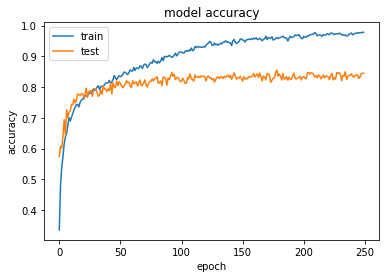

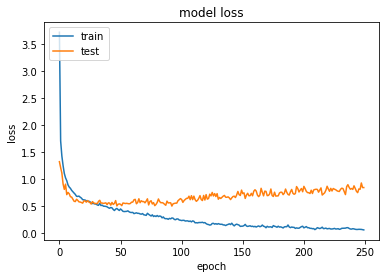

In [ ]:
with open(f'gdrive/MyDrive/Universidad/TFG/trainings/logs/{history_name}', "rb") as file_pi:
    history = pickle.load(file_pi)

# summarize history for accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
import wandb

run = wandb.init()
artifact = run.use_artifact('ava-research-hyper-kvasir/hyper-kvasir/model-warm-frog-3:v21', type='model')
artifact_dir = artifact.download()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: richardesp (ava-research-hyper-kvasir). Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact model-warm-frog-3:v21, 521.54MB. 4 files... 
wandb:   4 of 4 files downloaded.  
Done. 0:0:4.9


In [ ]:
model = keras.models.load_model('artifacts/model-warm-frog-3:v21')

In [ ]:
model.evaluate(X_test, y_test)

68/68 [==============================] - 6s 21ms/step - loss: 0.5700 - accuracy: 0.7905 - top-5-accuracy: 0.9874


[0.5700362920761108, 0.7905027866363525, 0.9874301552772522]